## 2_Training

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
# external dependencies
import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)
# import custom modules
import utils
import models
import dataloaders

# basic imports
import json
import pprint
import pickle
from tqdm.auto import tqdm, trange
from more_itertools import chunked

# scientific python
import matplotlib.pylab as plt
import numpy as np
import scipy as sp
import scipy.spatial.distance as spdist
import pandas as pd

RAND_SEED = 28
np.random.seed(RAND_SEED)

# ML/torch 
import ml_collections
import torch
from torch.utils.data import DataLoader, TensorDataset

# Scanpy modules
import scanpy as sc
import anndata

# Plotting
import seaborn as sns

device = torch.device("cuda")
#device = torch.device("cpu")
dtype = torch.float32

#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

utils.matplotlib_settings()
utils.print_module_versions([torch])

torch     : 1.6.0+cu101


# Load the preprocessed data

In [3]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [4]:
## puck data prefix
#PREFIX = 'sn'
#CELL_TYPE = 'mli2'
#PUCK_NUMBER = 'mli2_30genes_0.05_perturbed'
#dirname = f'latent_space_structure/data/{PREFIX}_{PUCK_NUMBER}'

#np_data = np.load(os.path.join(dirname, 'preprocessed_data.npz'))
#print(list(np_data.keys()))
#adata = sc.read(os.path.join(dirname, 'adata.h5ad'))

#batch = pd.read_csv(f'latent_space_structure/data/{CELL_TYPE}/{CELL_TYPE}_batch.csv')['x'].values
#adata.obs['batch'] = batch
#log_normalized_expression_ng = adata.X


# puck data prefix
PREFIX = 'citeseq_rna'#'sn'
PUCK_SUBNUMBER = 'naiveB_1900'#'mli2_30'
PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_100' #f'{PUCK_SUBNUMBER}genes_0.05_perturbed'

#CELL_TYPE = #'mli2'
#PUCK_SUBNUMBER = f'{CELL_TYPE}_10genes_0.05'
#PUCK_NUMBER = f'{PUCK_SUBNUMBER}_perturbed'
dirname = f'latent_space_structure/data/{PREFIX}_{PUCK_NUMBER}'

np_data = np.load(os.path.join(dirname, 'preprocessed_data.npz'))
print(list(np_data.keys()))
adata = sc.read(os.path.join(dirname, 'adata.h5ad'))

batch = pd.read_csv(f'latent_space_structure/data/{PUCK_NUMBER}/batch.csv')['x'].values
perturbed = pd.read_csv(f'latent_space_structure/data/{PUCK_NUMBER}/celltype.csv')['x'].values
#batch = pd.read_csv(f'latent_space_structure/data/{CELL_TYPE}/{CELL_TYPE}_batch.csv')['x'].values
#perturbed = pd.read_csv(f'latent_space_structure/data/{CELL_TYPE}/{PUCK_SUBNUMBER}_perturbed.csv')['x'].values

negative_batch_mask = batch == 0
positive_batch_mask = batch == 1
negative_perturbed_mask = perturbed == "Naive B"
positive_perturbed_mask = perturbed == "Memory B"

adata.obs['batch'] = batch
adata.obs['perturbed'] = perturbed
log_normalized_expression_ng = adata.X

['puck_number', 'n_filtered_genes', 'bead_efficiency_hvgs_n', 'bead_efficiency_n', 'filtered_expression_gn', 'mean_umi_hvgs', 'filtered_gene_names', 'bead_barcodes_n']


## Scale Data for PCA

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_log_normalized_expression_ng = scaler.fit_transform(log_normalized_expression_ng)

## Global model parameters

In [8]:
adata.varm['PCs'][:, 0:5].shape

(17009, 5)

In [12]:
CONFIG = ml_collections.ConfigDict()
CONFIG.puck_number = PUCK_NUMBER
CONFIG.n_beads = log_normalized_expression_ng.shape[0]
CONFIG.gene_dim = log_normalized_expression_ng.shape[1] # g

CONFIG.z_dim = 50 #adata.varm['PCs'].shape[1] # k

CONFIG.num_epochs = 2000#4000
CONFIG.batch_size = log_normalized_expression_ng.shape[0]#20000
CONFIG.learning_rate = 1e-4
CONFIG.betas = (0.99, 0.999)

CONFIG.initialize_with_pcaae = True
CONFIG.train_logistic = True
CONFIG.w_logistic = -1. # weight for the logistic loss in the objective function
CONFIG.label0_weight = 1. # weight for assymetrically penalizing label 0 predictions

if not CONFIG.train_logistic:
    MODEL_DIR = os.path.join(dirname, f"pca_ae_{CONFIG.z_dim}")
else:
    MODEL_DIR = os.path.join(dirname, f"pca_ae_{CONFIG.z_dim}_logistic_{CONFIG.w_logistic}_label0{CONFIG.label0_weight}")

CONFIG

batch_size: 2000
betas: !!python/tuple
- 0.99
- 0.999
gene_dim: 17009
initialize_with_pcaae: true
label0_weight: 1.0
learning_rate: 0.0001
n_beads: 2000
num_epochs: 2000
puck_number: naiveB_1900_memoryB_100
train_logistic: true
w_logistic: -1.0
z_dim: 50

## Define Models

In [13]:
class Linear_Encoder(torch.nn.Module):
    def __init__(self, 
                 gene_dim:int, 
                 z_dim:int):
        super(Linear_Encoder, self).__init__()
        self.gene_to_z = torch.nn.Linear(gene_dim, z_dim)
        
    def forward(self, 
                x_ng: torch.Tensor) -> torch.Tensor:
        z_nk = self.gene_to_z(x_ng)
        return z_nk

class Linear_Decoder(torch.nn.Module):
    def __init__(self, 
                 gene_dim:int,
                 z_dim:int):
        super(Linear_Decoder, self).__init__()
        self.z_to_gene = torch.nn.Linear(z_dim, gene_dim)
        
    def forward(self, 
                z_nk: torch.Tensor) -> torch.Tensor:
        x_reconstruct_ng = self.z_to_gene(z_nk)
        return x_reconstruct_ng
    
class LogisticRegressionTorch(torch.nn.Module):
     def __init__(self, 
                  z_dim:int):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = torch.nn.Linear(z_dim, 1)
     
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

## Utility functions

In [14]:
from sklearn.linear_model import LogisticRegression
import scipy as sp
from scipy.stats import describe as describe_stats


def standalone_logistic(X, y):
    clf = LogisticRegression(random_state=RAND_SEED, penalty='none').fit(X, y)
    predicted_label = clf.predict(X)
    predicted_prob = clf.predict_proba(X)
    return predicted_prob[:,1]

## Initialize Models

In [26]:
enc = Linear_Encoder(CONFIG.gene_dim, CONFIG.z_dim).to(device)
dec = Linear_Decoder(CONFIG.gene_dim, CONFIG.z_dim).to(device)

logistic_reg = LogisticRegressionTorch(CONFIG.z_dim).to(device)

In [27]:
# initialize the multi-loss autoencoder with the reconstruction loss one
if CONFIG.initialize_with_pcaae:
    dirname_pca = os.path.join(dirname, f"pca_ae_{CONFIG.z_dim}")
    print(f"Initializing enc and dec models from {dirname_pca}!")
    for key, model in {'enc_model_params':enc, 'dec_model_params':dec}.items():    
        fname = os.path.join(dirname_pca, f'{PREFIX}_{key}.pt' )
        model.load_state_dict(torch.load(fname))

Initializing enc and dec models from latent_space_structure/data/citeseq_rna_naiveB_1900_memoryB_100/pca_ae_50!


## Data Loader

In [28]:
full_x_ng = torch.from_numpy(scaled_log_normalized_expression_ng)
full_y = torch.from_numpy(batch.astype(np.float32))
weight_n = torch.ones_like(full_y)
weight_n[full_y==0] = CONFIG.label0_weight
indices = torch.arange(len(batch))

dataset = torch.utils.data.TensorDataset(full_x_ng, full_y, weight_n, indices)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=CONFIG.batch_size, shuffle=True)

In [29]:
minix, miniy, miniw, index = next(iter(data_loader))
torch.nn.functional.binary_cross_entropy(miniy, miniy, weight=miniw, reduction='none')

tensor([-0., -0., 0.,  ..., 0., 0., -0.])

## Losses

In [30]:
ae_loss = torch.nn.MSELoss(reduction='none')
#logistic_loss = torch.nn.BCELoss(reduction='none') 
#logistic_loss = torch.nn.functional.binary_cross_entropy(reduction='none')

## Training Loop

In [20]:
df = pd.DataFrame()
df['batch'] = adata.obs['batch'].values.astype(int)
df['perturbed'] = adata.obs['perturbed'].values

In [21]:
all_trainable_params = utils.get_trainable_params(enc) + utils.get_trainable_params(dec) + utils.get_trainable_params(logistic_reg)
optimizer = torch.optim.Adam(all_trainable_params,lr=CONFIG.learning_rate, betas=CONFIG.betas)
history = []

In [22]:
CONFIG.num_epochs = 50

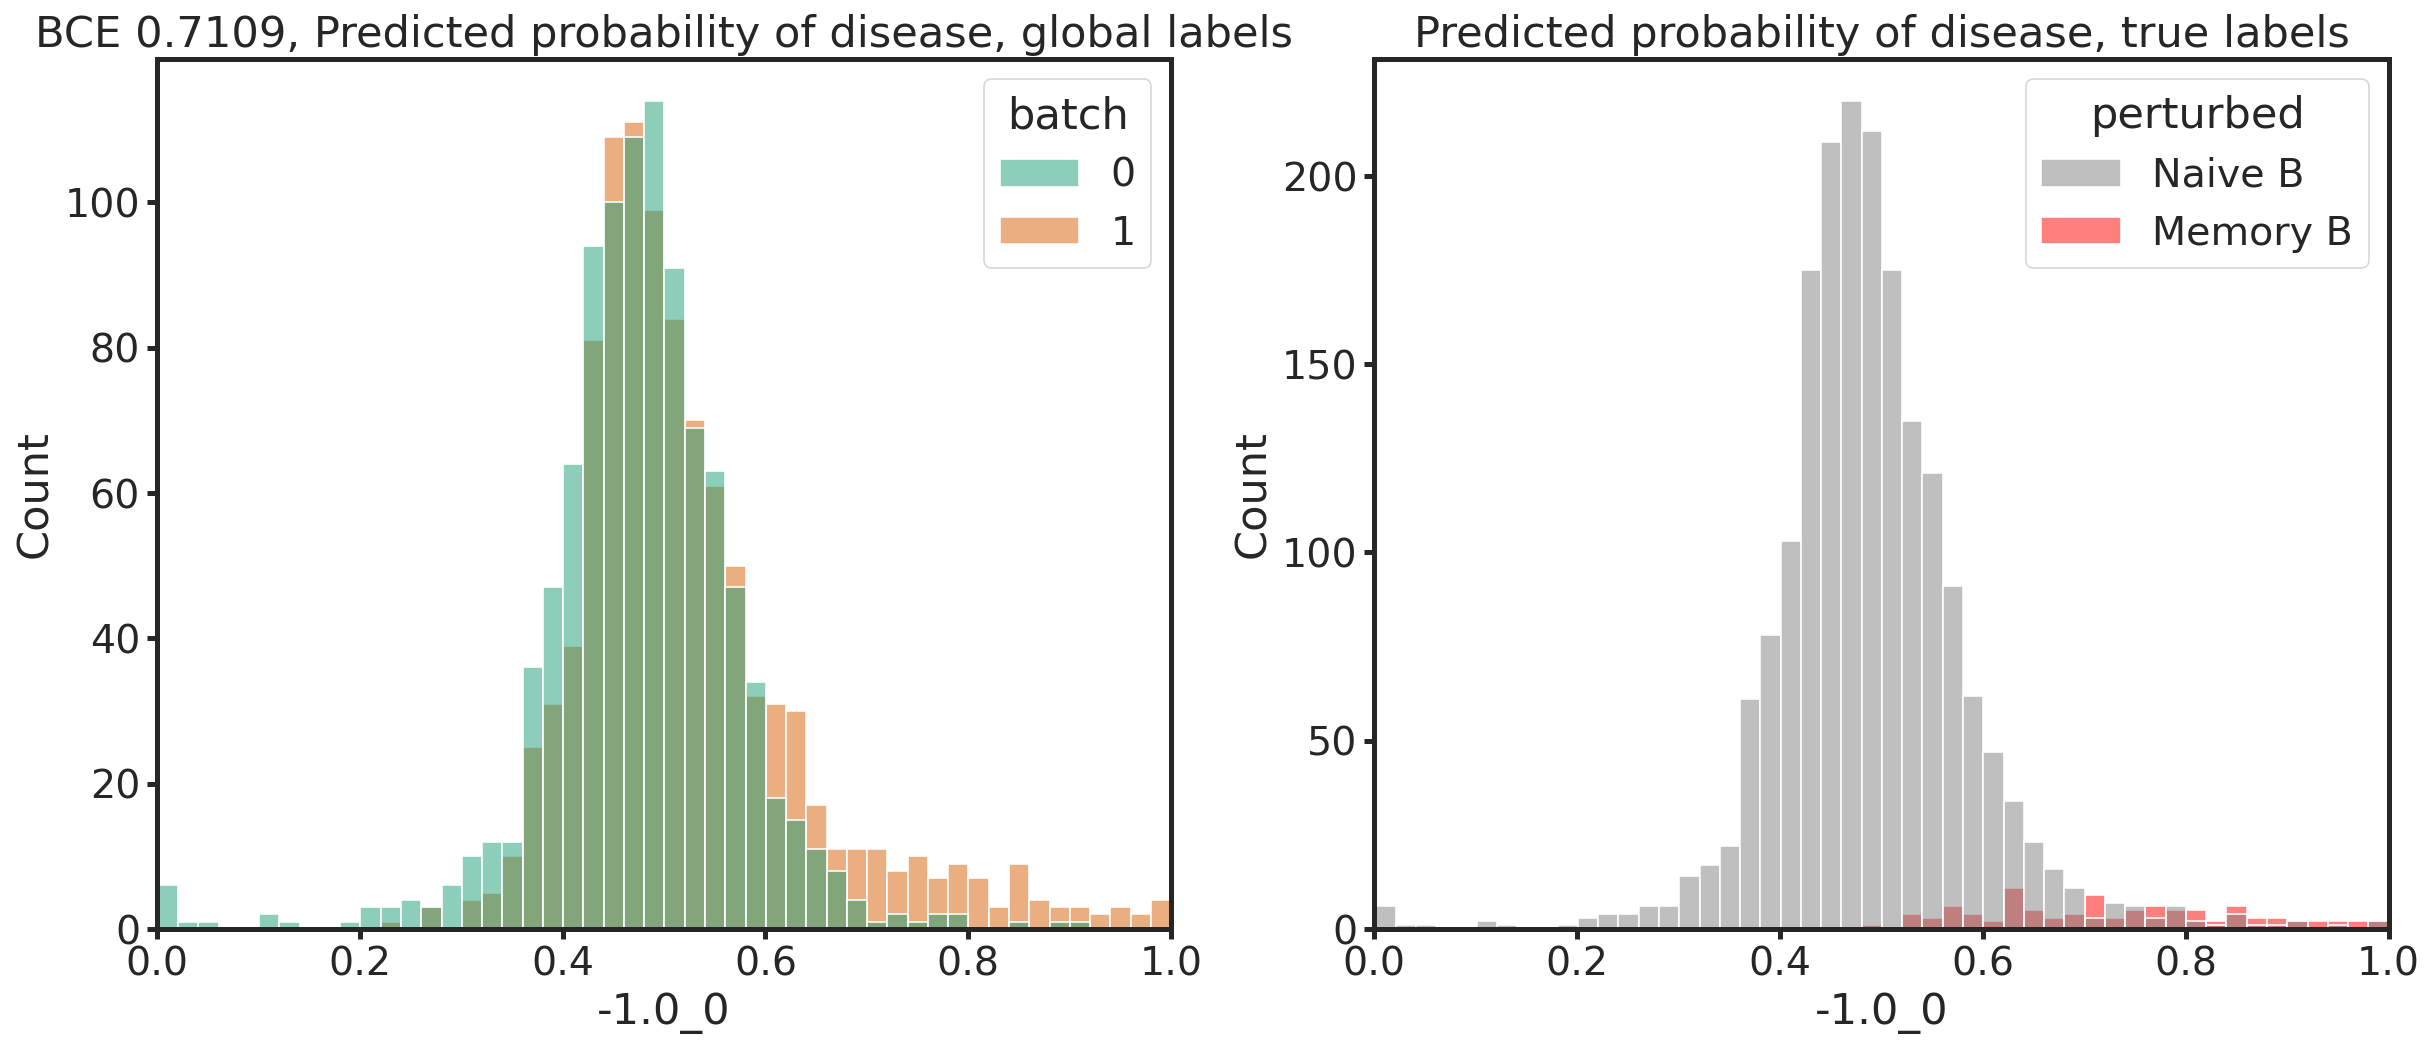

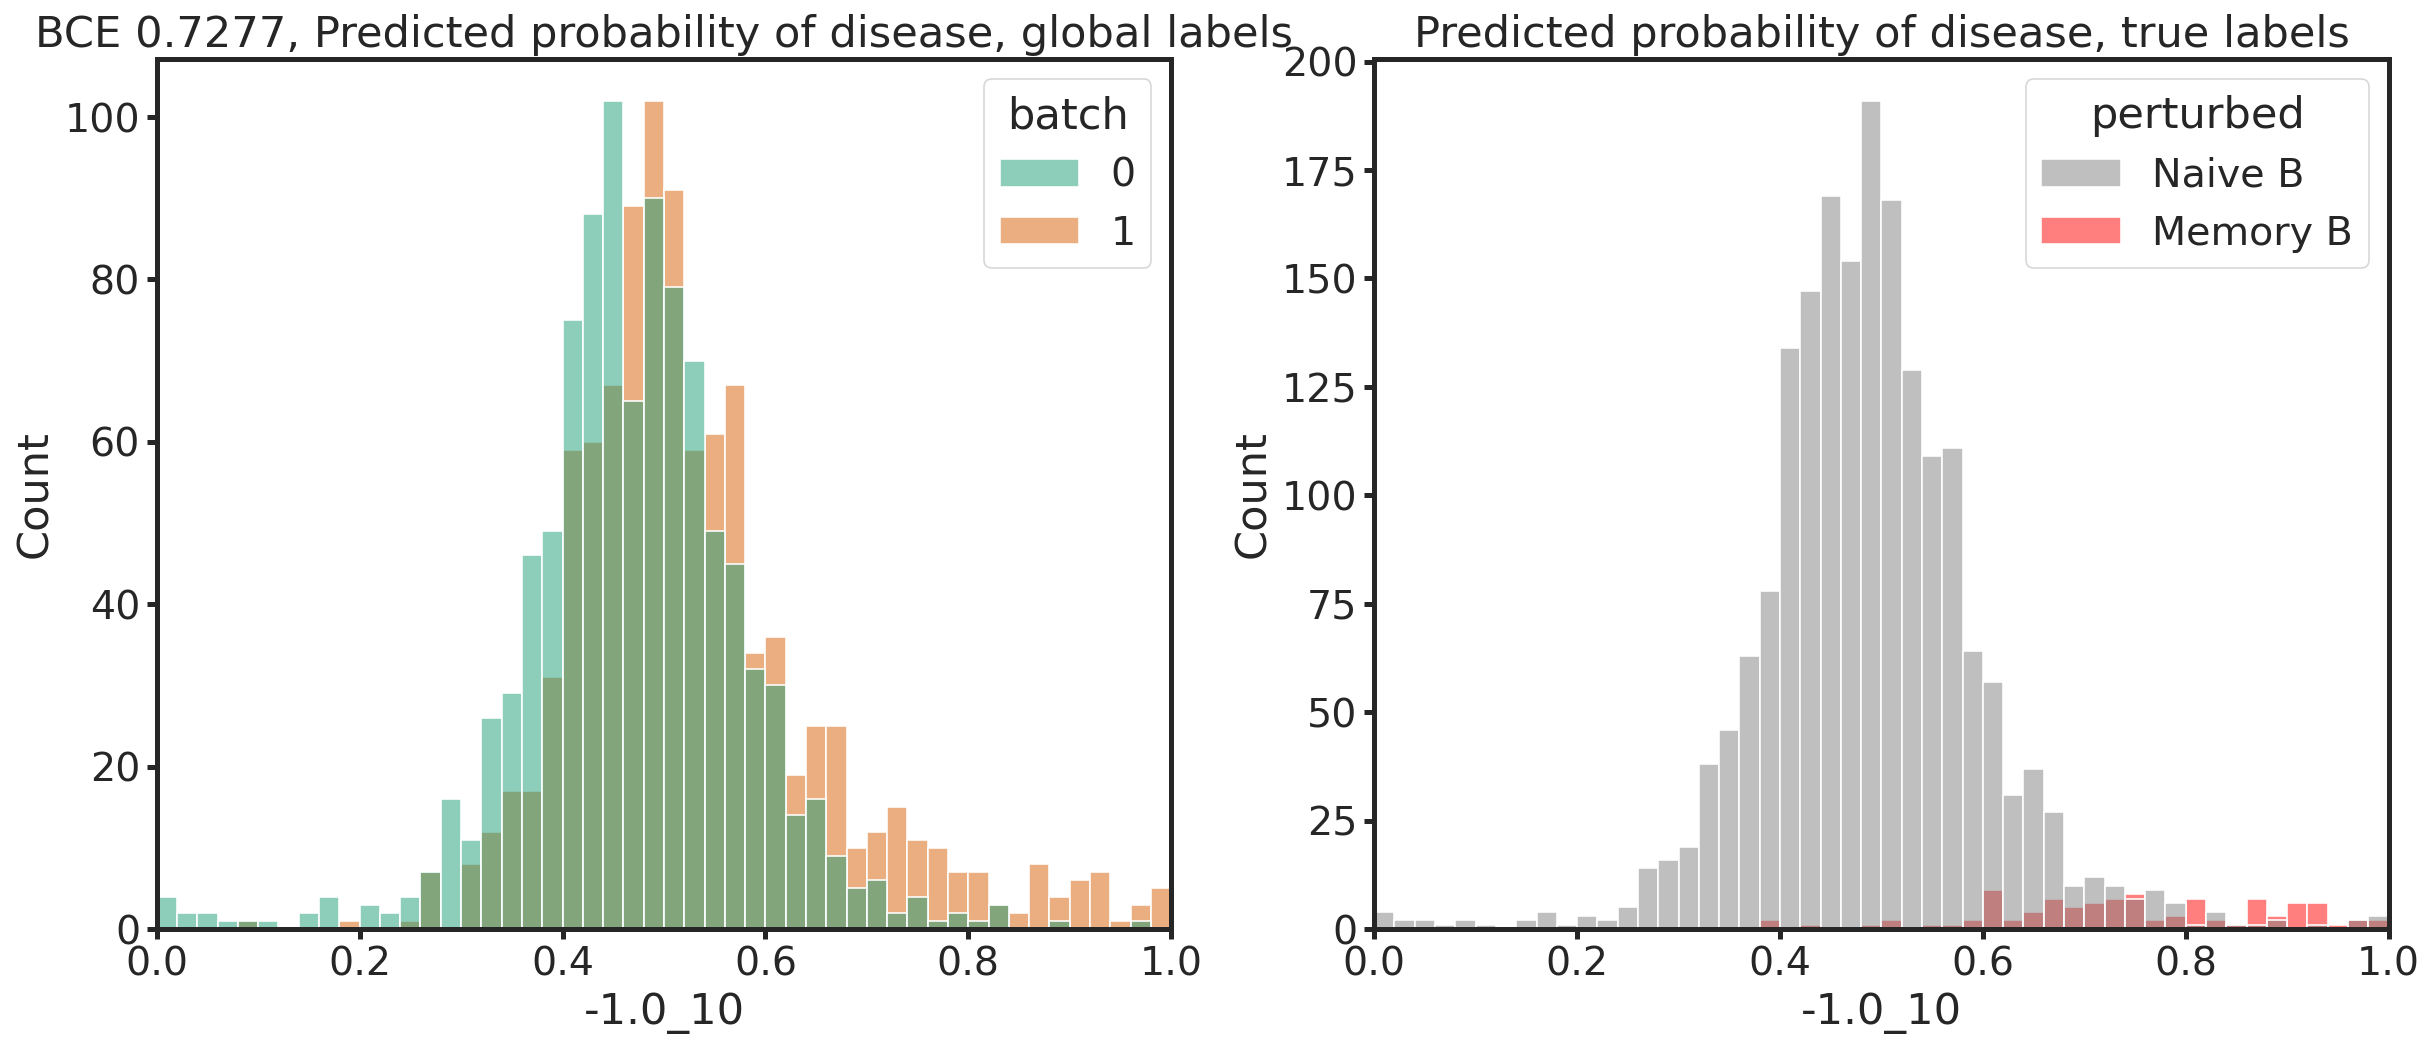

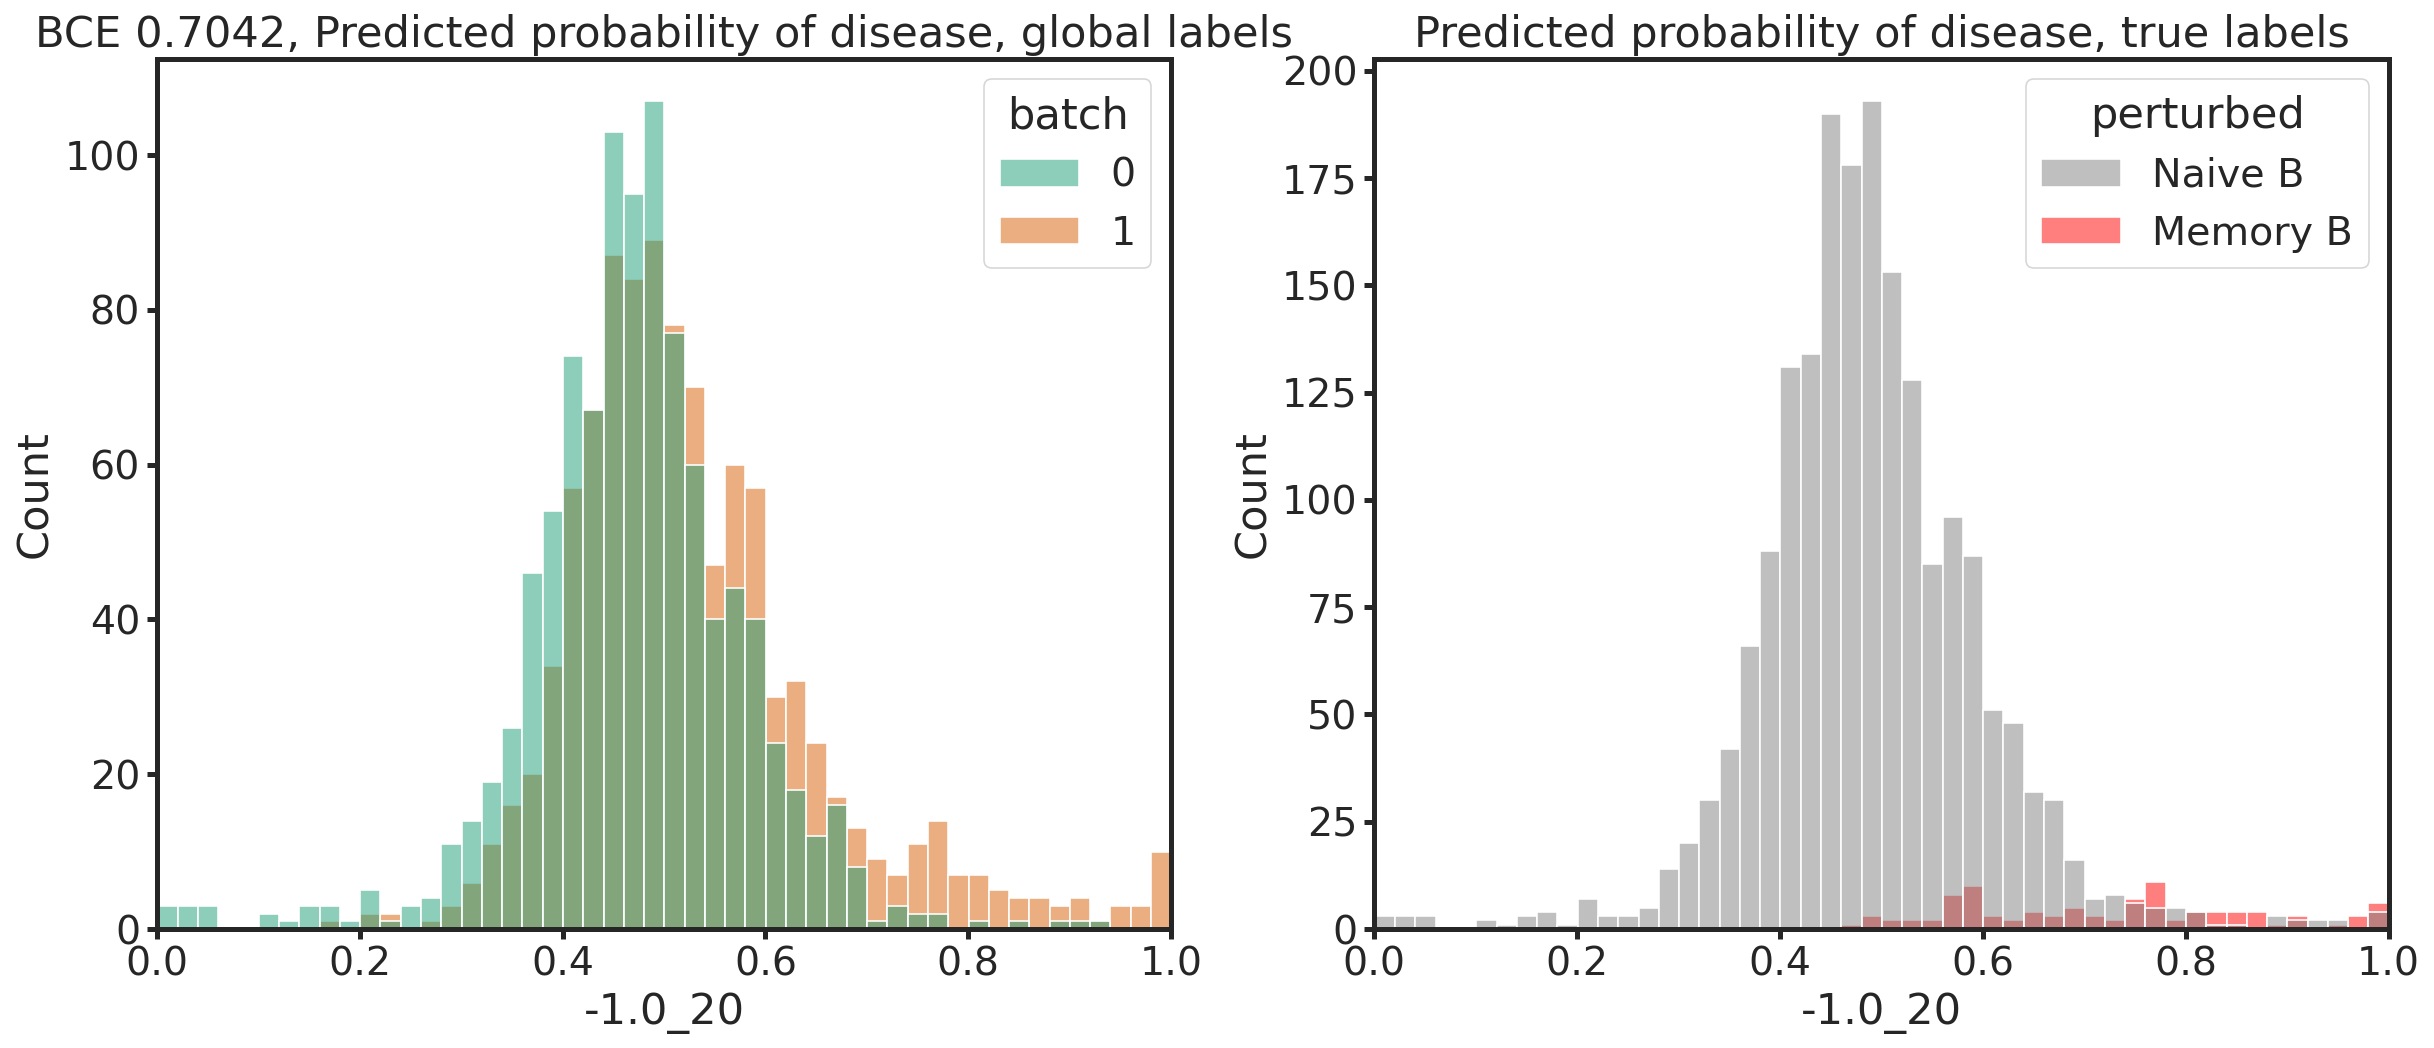

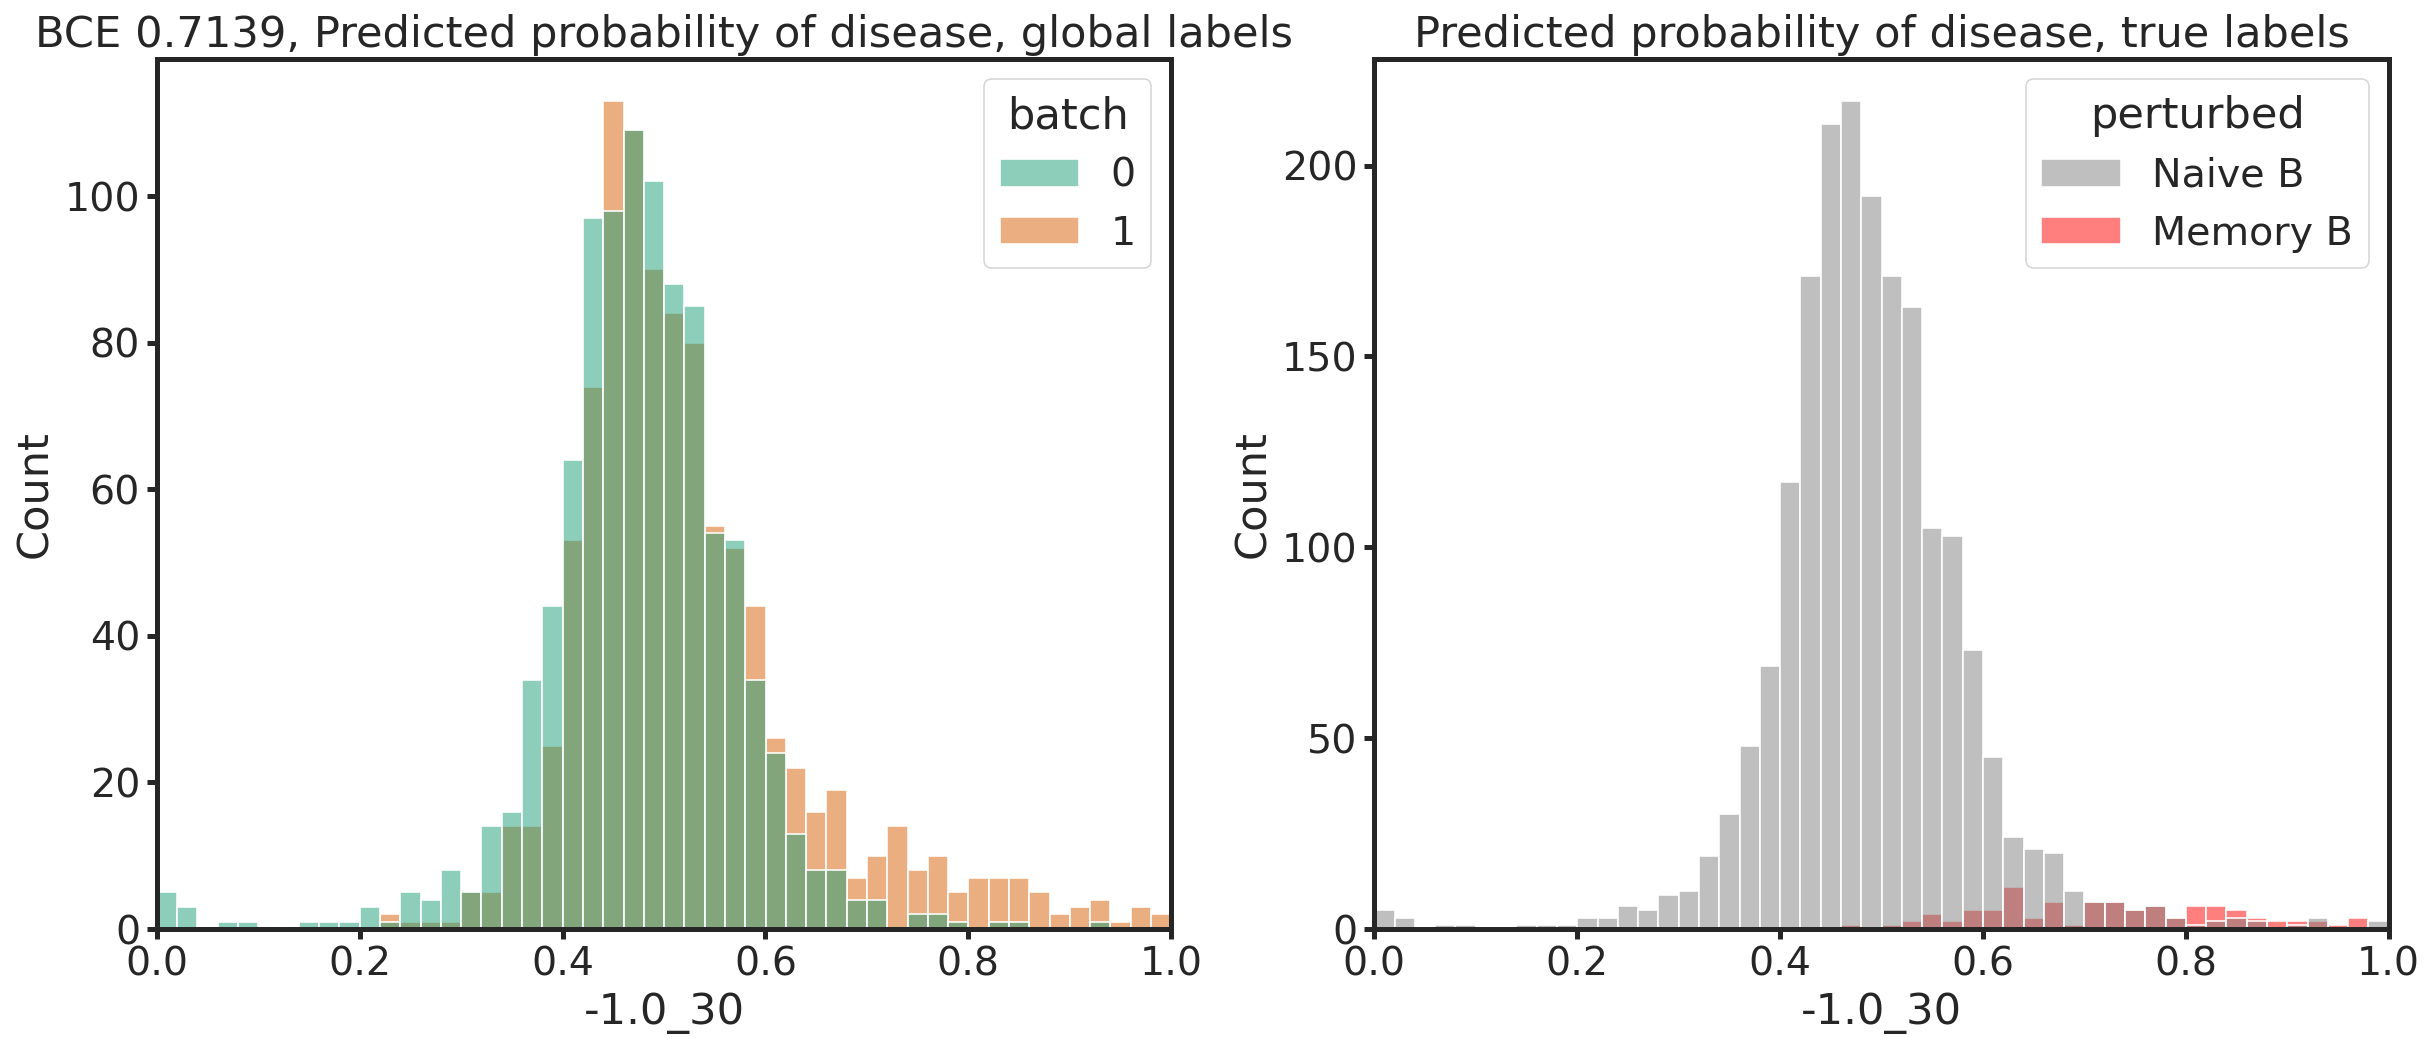

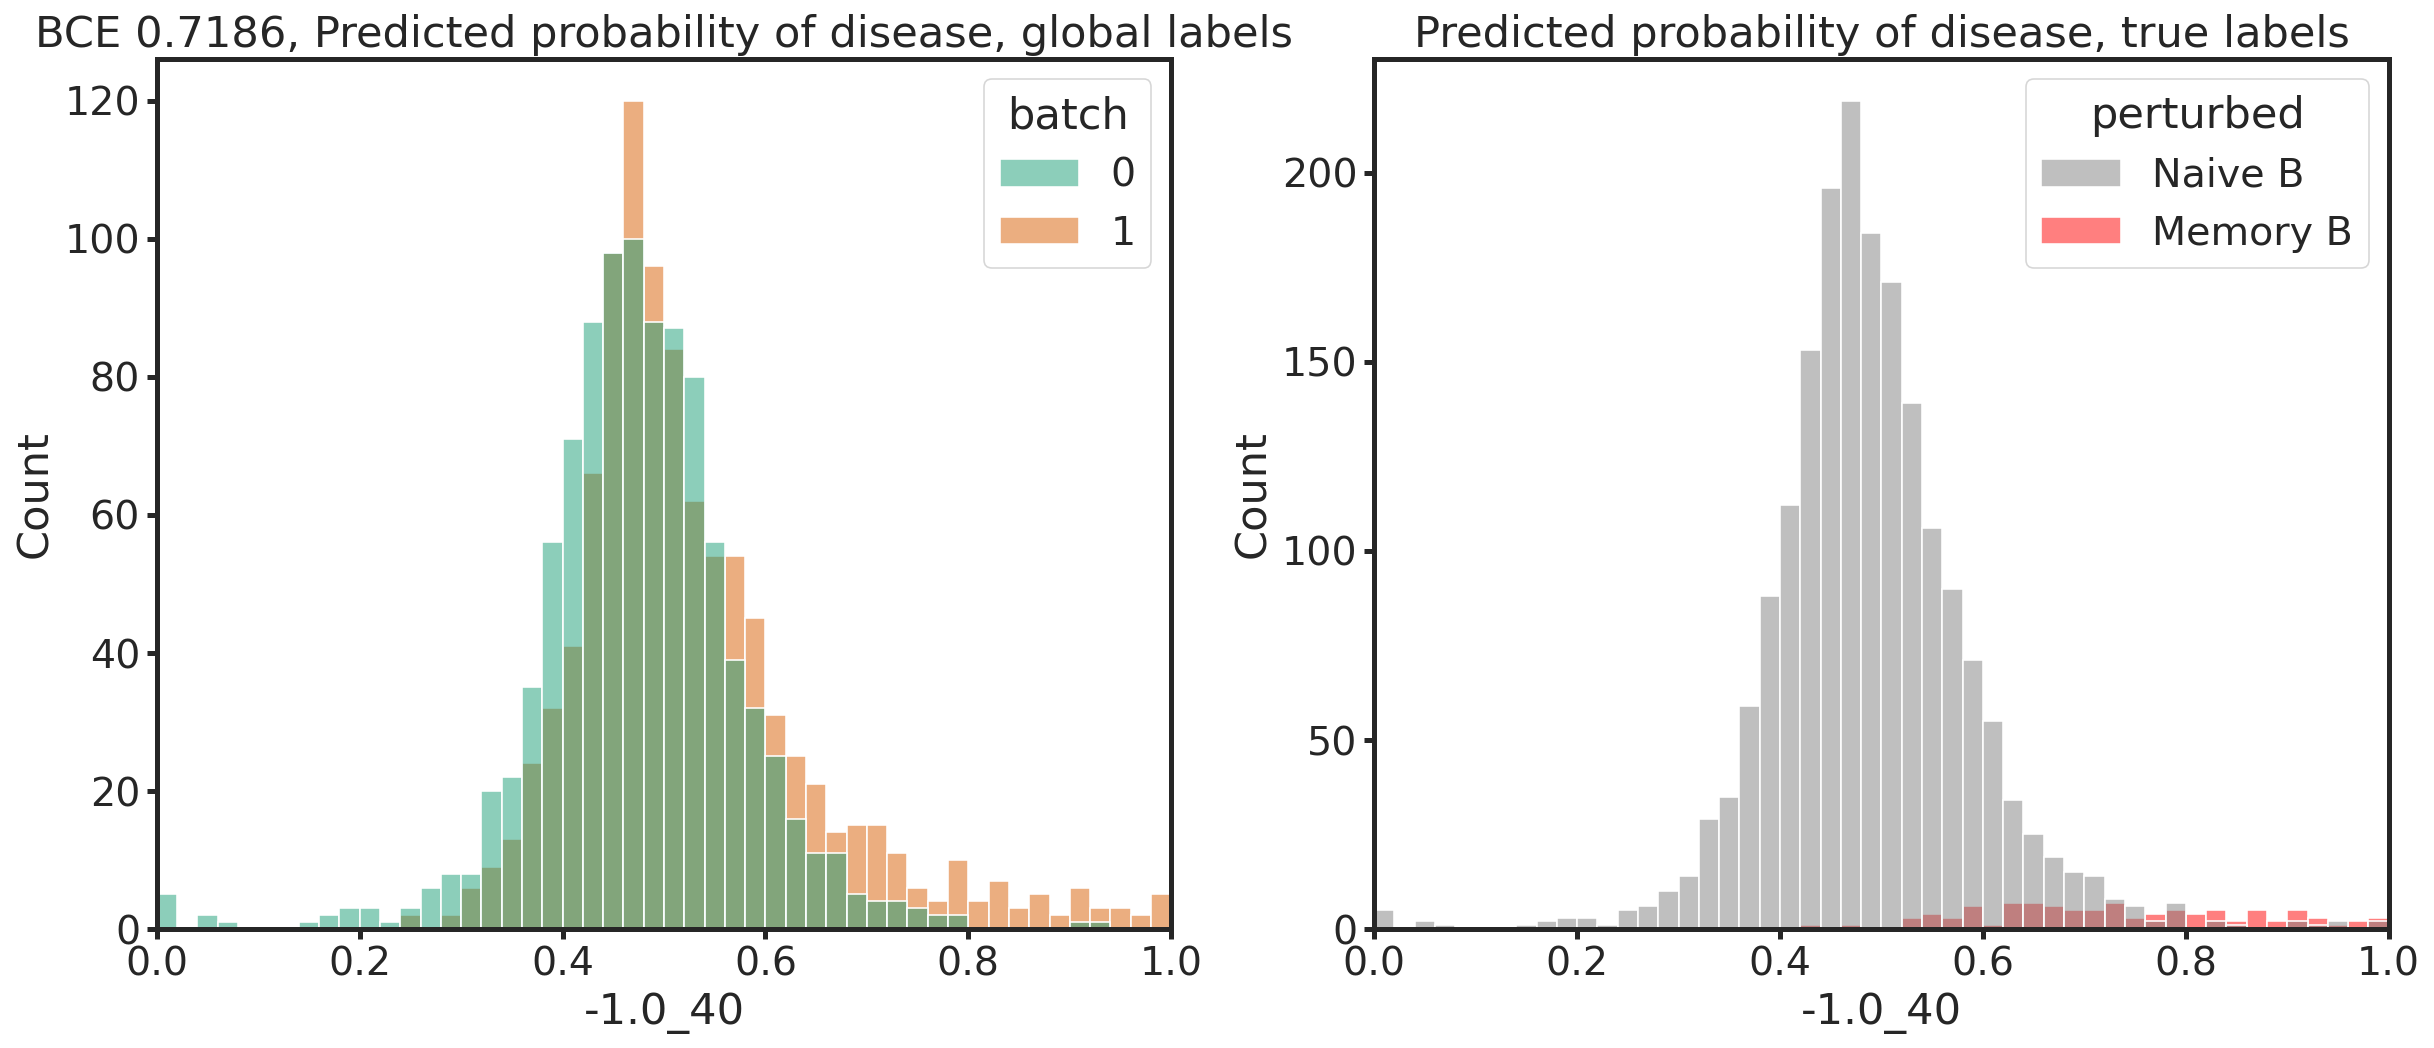

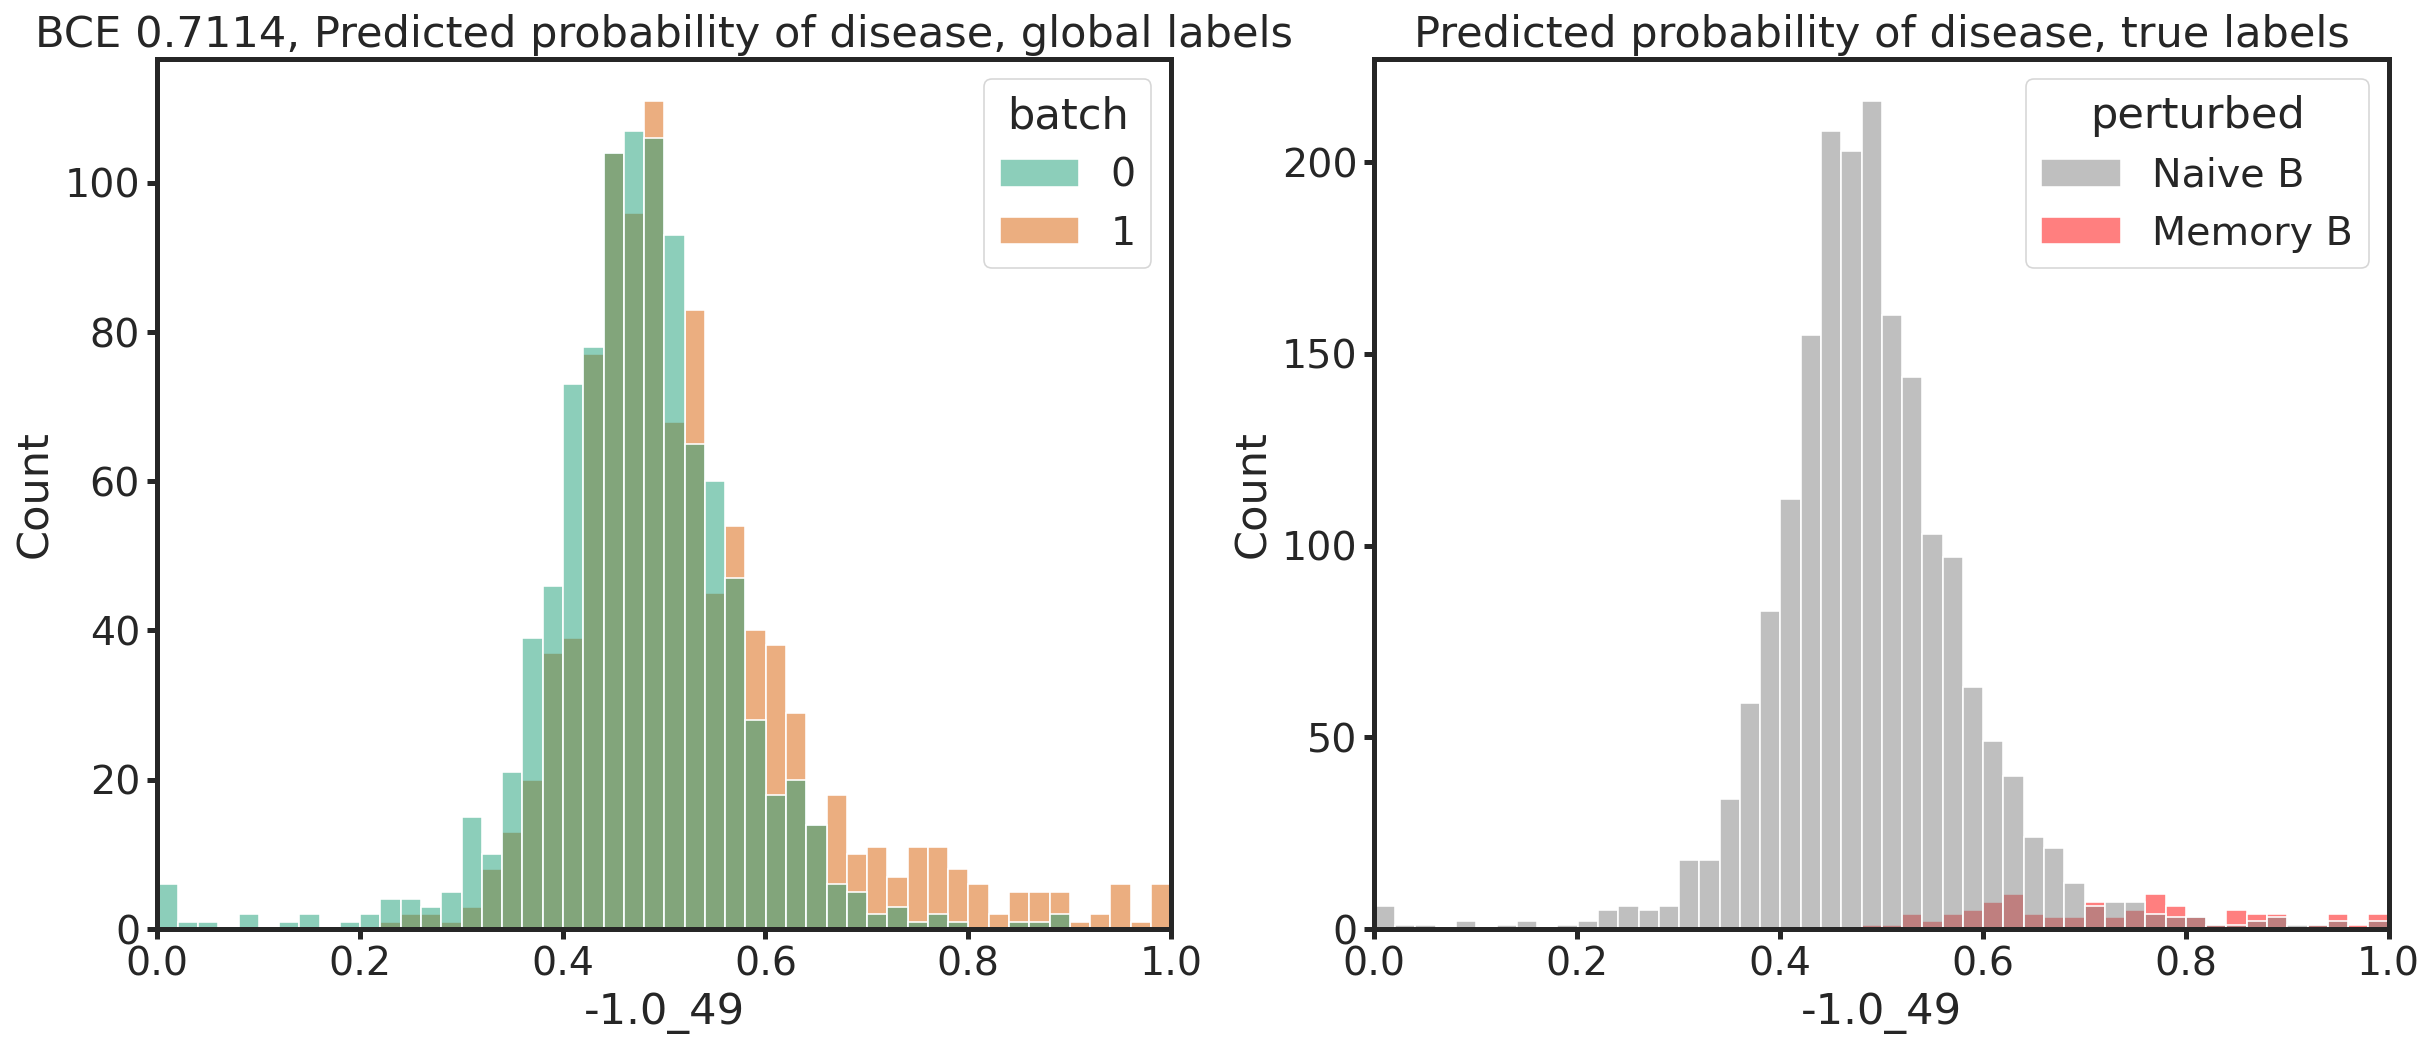

In [23]:
pbar = tqdm(range(CONFIG.num_epochs))
for epoch in pbar:
    for x_ng, y_n, weight_n, index in data_loader:
        x_ng = x_ng.to(device)
        y_n = y_n.to(device)
        weight_n = weight_n.to(device)
        z_nk = enc(x_ng)
        y_pred_n = logistic_reg(z_nk).squeeze()
        x_reconstruct_ng = dec(z_nk)

        nll_ng = ae_loss(x_reconstruct_ng, x_ng)
        bce_n = torch.nn.functional.binary_cross_entropy(y_pred_n, y_n, weight=weight_n, reduction='none')
        # reduce
        batch_size = x_ng.shape[0]
        nll = nll_ng.sum() / batch_size
        bce = bce_n.sum() / batch_size

        loss = nll
        if CONFIG.train_logistic:
            loss = loss + CONFIG.w_logistic * bce

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses = {'total_loss':loss.item(), 'nll':nll.item(), 'bce':bce.item(), 'epoch':epoch}
        pbar.set_postfix({k:f'{v:.4f}' for k,v in losses.items()})
        history.append(losses)
        
        if epoch%10==0 or epoch == CONFIG.num_epochs-1:
            # stand-alone logistic on z_nk
            X = z_nk.detach().cpu().numpy()
            y = y_n.detach().cpu().numpy()
            column = f'{CONFIG.w_logistic}_{epoch}'
            inverse_index = np.array([np.argmax(index == i).item() for i in np.arange(len(batch))])
            p_hat = standalone_logistic(X, y)[inverse_index]
            df[column] = p_hat
            
            f, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
            sns.histplot(x=column, hue='batch', palette={0:"#1B9E77",1:"#D95F02"}, ax=axes[0], data=df, bins=50)
            axes[0].set_title(f'BCE {bce:.4f}, Predicted probability of disease, global labels')
            axes[0].set_xlim([0, 1])
            sns.histplot(x=column, hue='perturbed', palette={'Naive B':'gray','Memory B':'red'}, ax=axes[1], data=df, bins=50)
            axes[1].set_title('Predicted probability of disease, true labels')
            axes[1].set_xlim([0, 1])
            plt.show()

            # visualize the predicted probability over the perturbed and unperturbed cells
            #plt.figure(figsize=(20, 10))
            #plt.subplot(2, 2, 1)
            #sns.distplot(p_hat[negative_batch_mask], color="#1B9E77", label='Batch=0')
            #sns.distplot(p_hat[positive_batch_mask], color="#D95F02", label='Batch=1')
            #plt.title(f'Epoch {epoch}, Predicted probability of disease, global labels')
            #plt.legend()
            #plt.subplot(2, 2, 2)
            #sns.distplot(p_hat[negative_perturbed_mask], color='gray', label='Naive B')
            #sns.distplot(p_hat[positive_perturbed_mask], color='red', label='Memory B')
            #plt.title('Predicted probability of disease, true labels')
            #plt.legend()
            #plt.show()

In [24]:
df

,batch,perturbed,-1.0_0,-1.0_10,-1.0_20,-1.0_30,-1.0_40,-1.0_49
0,1,Naive B,0.533671,0.401212,0.702875,0.510677,0.489944,0.586839
1,1,Naive B,0.427432,0.463871,0.393557,0.442185,0.444323,0.412855
2,0,Naive B,0.411398,0.382130,0.406338,0.436566,0.375288,0.406988
3,0,Naive B,0.422172,0.342492,0.451506,0.414282,0.410910,0.418500
4,1,Naive B,0.541128,0.526639,0.528803,0.534597,0.554436,0.538764
...,...,...,...,...,...,...,...,...
1995,1,Memory B,0.641813,0.680217,0.627392,0.654129,0.657724,0.643819
1996,1,Memory B,0.994905,0.989978,0.997626,0.957457,0.999373,0.995180
1997,1,Memory B,0.706950,0.729391,0.712829,0.707408,0.684098,0.712354
1998,1,Memory B,0.562101,0.588870,0.479900,0.675752,0.475470,0.550578


In [ ]:
# reinitialize the encoder, decoder, and logistic regression

In [31]:
df1 = pd.DataFrame()
df1['batch'] = adata.obs['batch'].values.astype(int)
df1['perturbed'] = adata.obs['perturbed'].values

all_trainable_params = utils.get_trainable_params(enc) + utils.get_trainable_params(dec) + utils.get_trainable_params(logistic_reg)
optimizer = torch.optim.Adam(all_trainable_params,lr=CONFIG.learning_rate, betas=CONFIG.betas)
history = []

CONFIG.num_epochs = 50

pbar = tqdm(range(CONFIG.num_epochs))
for epoch in pbar:
    for x_ng, y_n, weight_n, index in data_loader:
        x_ng = x_ng.to(device)
        y_n = y_n.to(device)
        weight_n = weight_n.to(device)
        z_nk = enc(x_ng)
        y_pred_n = logistic_reg(z_nk).squeeze()
        x_reconstruct_ng = dec(z_nk)

        nll_ng = ae_loss(x_reconstruct_ng, x_ng)
        bce_n = torch.nn.functional.binary_cross_entropy(y_pred_n, y_n, weight=weight_n, reduction='none')
        # reduce
        batch_size = x_ng.shape[0]
        nll = nll_ng.sum() / batch_size
        bce = bce_n.sum() / batch_size

        loss = nll
        if CONFIG.train_logistic:
            loss = loss + CONFIG.w_logistic * bce

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses = {'total_loss':loss.item(), 'nll':nll.item(), 'bce':bce.item(), 'epoch':epoch}
        pbar.set_postfix({k:f'{v:.4f}' for k,v in losses.items()})
        history.append(losses)
        
        if epoch%10==0 or epoch == CONFIG.num_epochs-1:
            # stand-alone logistic on z_nk
            X = z_nk.detach().cpu().numpy()
            y = y_n.detach().cpu().numpy()
            column = f'{CONFIG.w_logistic}_{epoch}'
            inverse_index = np.array([np.argmax(index == i).item() for i in np.arange(len(batch))])
            p_hat = standalone_logistic(X, y)[inverse_index]
            df1[column] = p_hat
            
df1

,batch,perturbed,-1.0_0,-1.0_10,-1.0_20,-1.0_30,-1.0_40,-1.0_49
0,1,Naive B,0.533671,0.664845,0.456688,0.555517,0.549076,0.534230
1,1,Naive B,0.427432,0.426058,0.434953,0.431902,0.427168,0.421180
2,0,Naive B,0.411398,0.522684,0.355010,0.422418,0.453267,0.388562
3,0,Naive B,0.422172,0.401218,0.408205,0.380418,0.462122,0.423402
4,1,Naive B,0.541128,0.573533,0.496675,0.535522,0.562036,0.528682
...,...,...,...,...,...,...,...,...
1995,1,Memory B,0.641813,0.613643,0.675917,0.632641,0.644259,0.649139
1996,1,Memory B,0.994905,0.999975,0.936647,0.989261,0.999414,0.989167
1997,1,Memory B,0.706950,0.720146,0.704574,0.715819,0.698131,0.693538
1998,1,Memory B,0.562101,0.689351,0.448611,0.533594,0.690859,0.504537


In [32]:
df

,batch,perturbed,-1.0_0,-1.0_10,-1.0_20,-1.0_30,-1.0_40,-1.0_49
0,1,Naive B,0.533671,0.401212,0.702875,0.510677,0.489944,0.586839
1,1,Naive B,0.427432,0.463871,0.393557,0.442185,0.444323,0.412855
2,0,Naive B,0.411398,0.382130,0.406338,0.436566,0.375288,0.406988
3,0,Naive B,0.422172,0.342492,0.451506,0.414282,0.410910,0.418500
4,1,Naive B,0.541128,0.526639,0.528803,0.534597,0.554436,0.538764
...,...,...,...,...,...,...,...,...
1995,1,Memory B,0.641813,0.680217,0.627392,0.654129,0.657724,0.643819
1996,1,Memory B,0.994905,0.989978,0.997626,0.957457,0.999373,0.995180
1997,1,Memory B,0.706950,0.729391,0.712829,0.707408,0.684098,0.712354
1998,1,Memory B,0.562101,0.588870,0.479900,0.675752,0.475470,0.550578


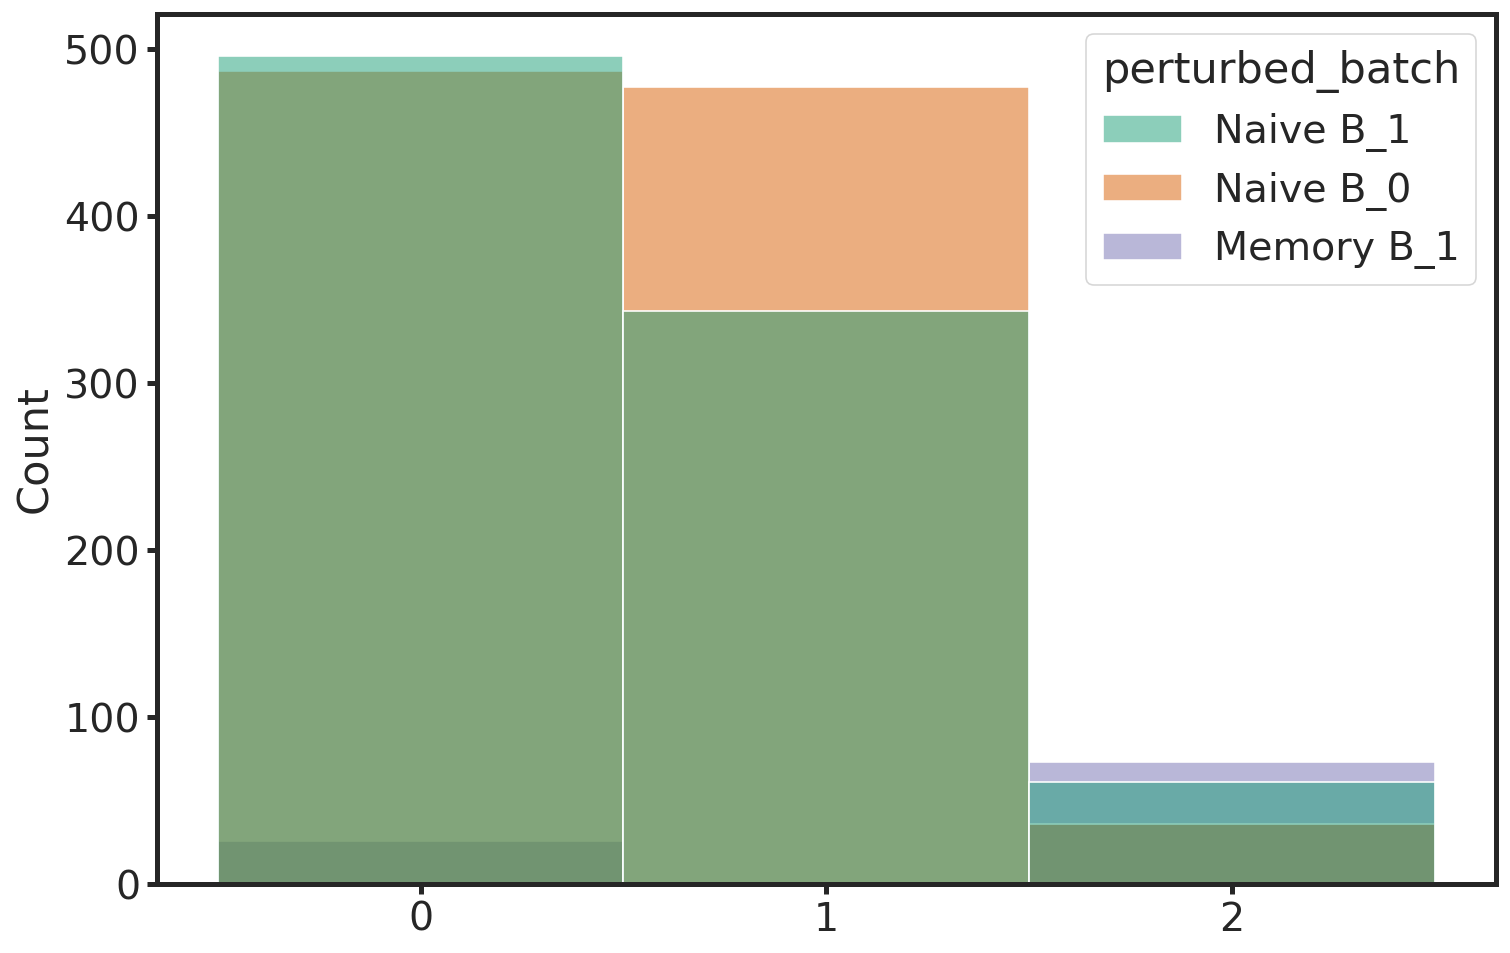

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(df.drop(['batch', 'perturbed'], axis=1))
kmeans.labels_
#kmeans.cluster_centers_

df_kmeans = df.copy()
df_kmeans['perturbed_batch'] = df_kmeans.apply(lambda row: f'{row["perturbed"]}_{row["batch"]}', axis=1)
df_kmeans['kmeans_labels'] = kmeans.labels_
#df_kmeans.head()
sns.histplot(x=kmeans.labels_.astype('str'), 
             hue='perturbed_batch', 
             palette=sns.color_palette('Dark2', 3), 
             #ax=axes[1], 
             data=df_kmeans)
plt.show()

In [20]:
#!conda install -c conda-forge -n vizi -y tslearn
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(df.drop(['batch', 'perturbed'], axis=1))

/opt/conda/envs/vizi/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


KeyboardInterrupt: 

In [21]:
epoch_col_map = {c: int(c.split('_')[1]) for c in df.columns if c.startswith(f'{CONFIG.w_logistic}_')}
df_melt = df.rename(columns=epoch_col_map)
df_melt['perturbed_batch'] = df_melt.apply(lambda row: f'{row["perturbed"]}_{row["batch"]}', axis=1)
df_melt = df_melt.reset_index().rename(columns={'index':'cell_id'})
df_melt = pd.melt(df_melt, id_vars=['cell_id','perturbed_batch'], value_vars= list(epoch_col_map.values()))
df_melt = df_melt.rename(columns={'variable':'epoch','value':'p_hat'})

In [22]:
df_melt

,cell_id,perturbed_batch,epoch,p_hat
0,0,Naive B_1,0,0.533671
1,1,Naive B_1,0,0.427432
2,2,Naive B_0,0,0.411398
3,3,Naive B_0,0,0.422172
4,4,Naive B_1,0,0.541128
...,...,...,...,...
401995,1995,Memory B_1,1999,0.797714
401996,1996,Memory B_1,1999,0.996367
401997,1997,Memory B_1,1999,0.902795
401998,1998,Memory B_1,1999,0.743198


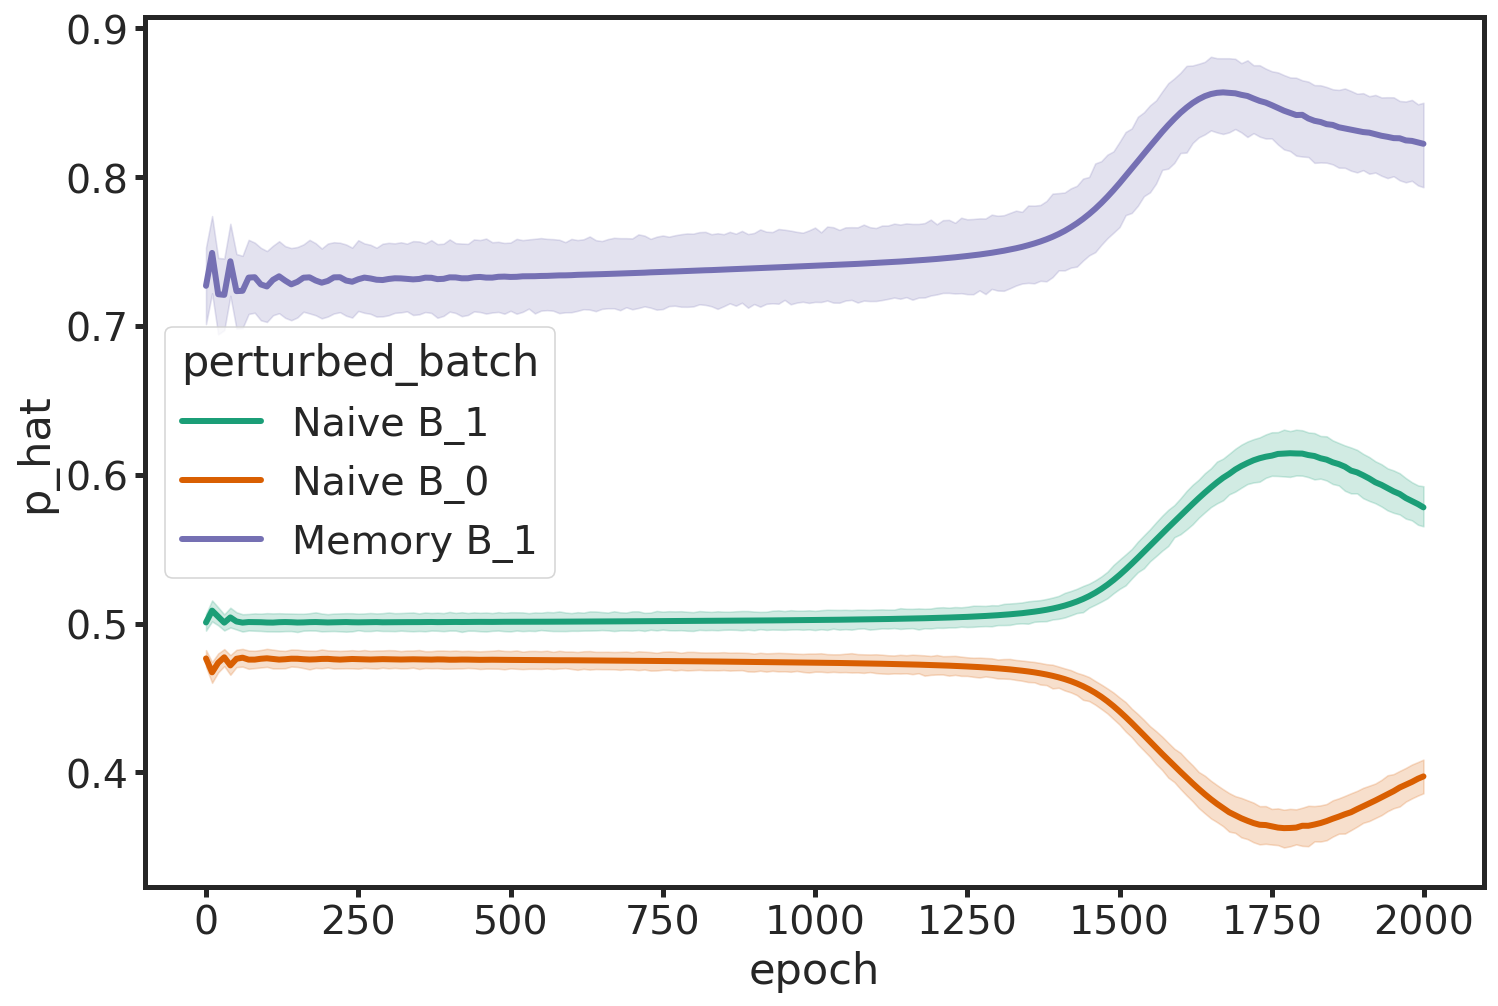

In [ ]:
sns.lineplot(x='epoch', y='p_hat', hue='perturbed_batch', palette='Dark2', data=df_melt)
plt.show()
color_map = dict(zip(df_melt['perturbed_batch'].unique(),sns.color_palette('Dark2')))
for p_batch, grp1 in df_melt.groupby('perturbed_batch'):
    c = color_map[p_batch]
    for cell_id, grp2 in grp1.groupby('cell_id'):
        plt.plot(grp2['epoch'], grp2['p_hat'],c=c,alpha=0.1)
    plt.xlabel('epochs')
    plt.ylabel('p_hat')
    plt.title(p_batch)
    plt.show()

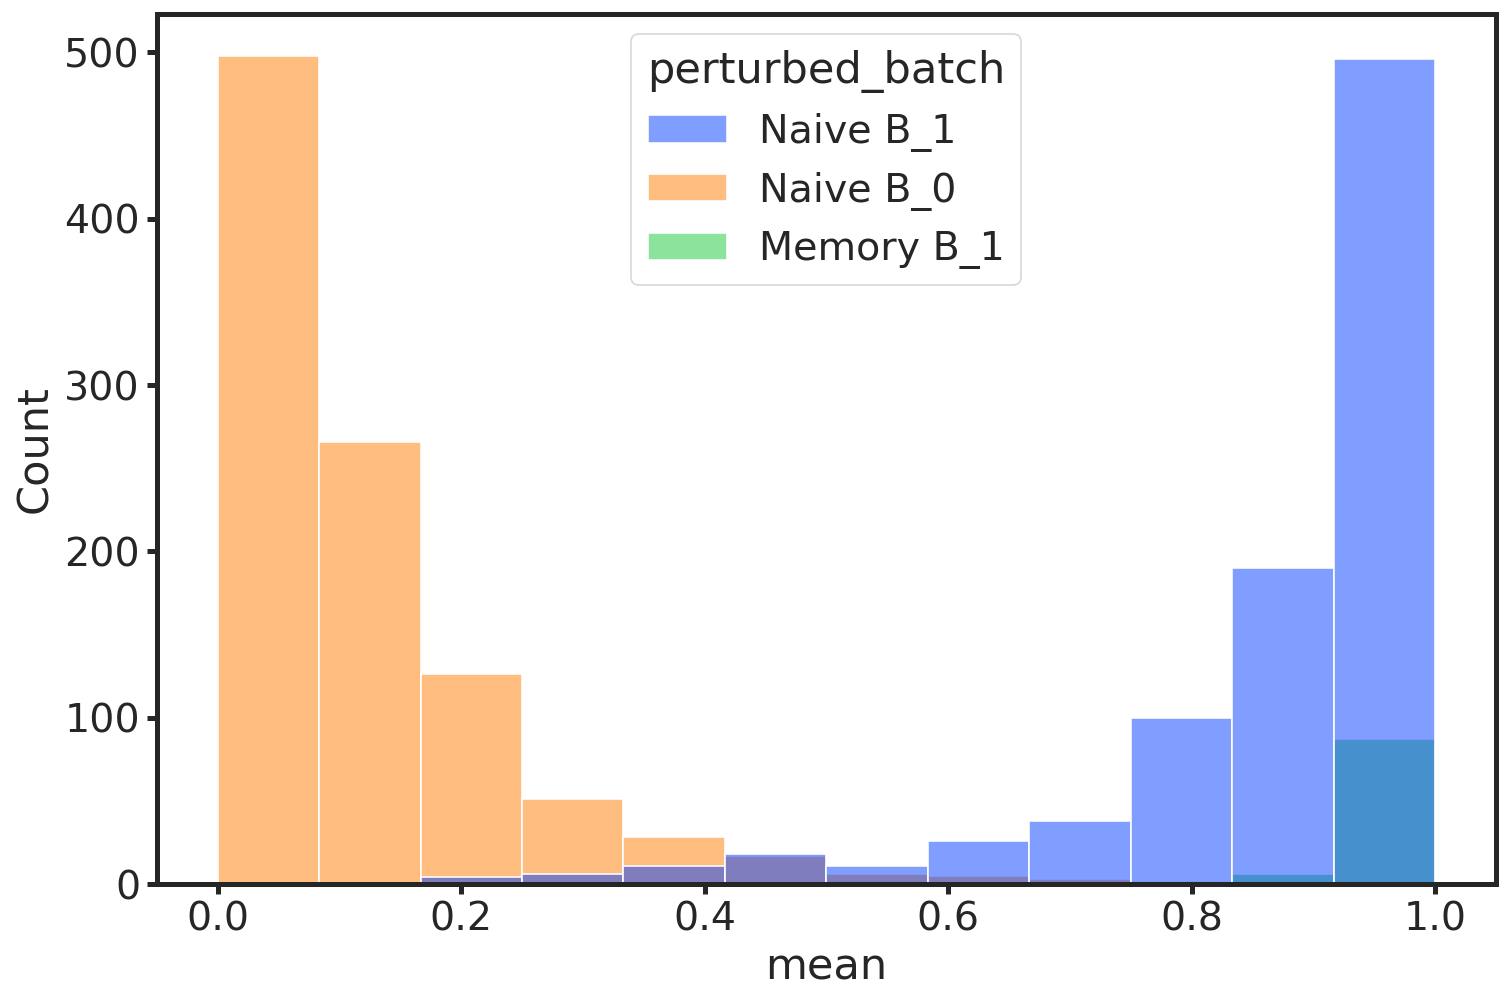

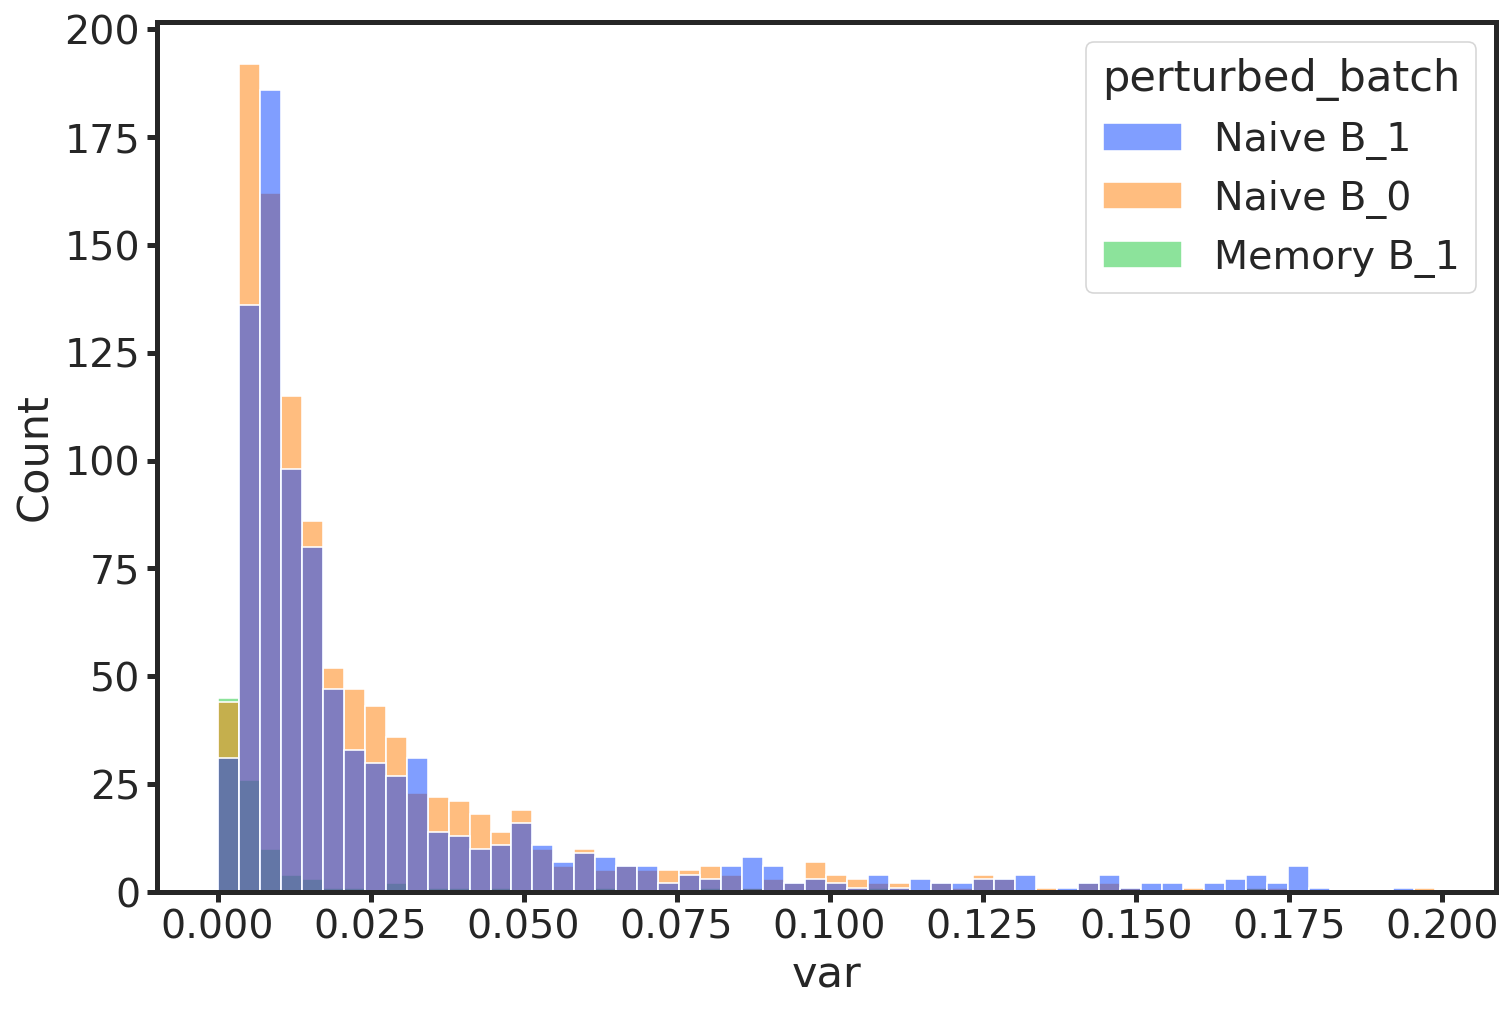

In [77]:
var_df = df_melt.groupby(['cell_id','perturbed_batch'])['p_hat'].agg(['mean','var']).reset_index()
#display(var_df.head())
sns.histplot(x='mean', hue='perturbed_batch', data=var_df)
plt.show()
sns.histplot(x='var', hue='perturbed_batch', data=var_df)
plt.show()

In [78]:
# note this is the PCA loss computed on the entire dataset with 50 PCs
target_loss = ae_loss(full_x_ng.to(device), torch.from_numpy(np.matmul(adata.obsm['X_pca'], adata.varm['PCs'].T)).to(device)).sum() / full_x_ng.shape[0]
target_loss

tensor(13885.5947, device='cuda:0')

In [79]:
results_df = pd.DataFrame(history)
results_df['iter'] = results_df.index.tolist()
results_df.head()

,total_loss,nll,bce,epoch,iter
0,13741.835938,13705.714844,3.612083,0,0
1,13742.408203,13708.872070,3.353569,1,1
2,13741.827148,13708.824219,3.300293,2,2
3,13741.588867,13708.382812,3.320592,3,3
4,13741.541016,13707.940430,3.360017,4,4


In [80]:
results_df.tail()

,total_loss,nll,bce,epoch,iter
386,13714.958984,13708.455078,0.650398,386,386
387,13714.842773,13708.432617,0.641062,387,387
388,13714.727539,13708.409180,0.631792,388,388
389,13714.611328,13708.385742,0.622588,389,389
390,13714.496094,13708.361328,0.613455,390,390


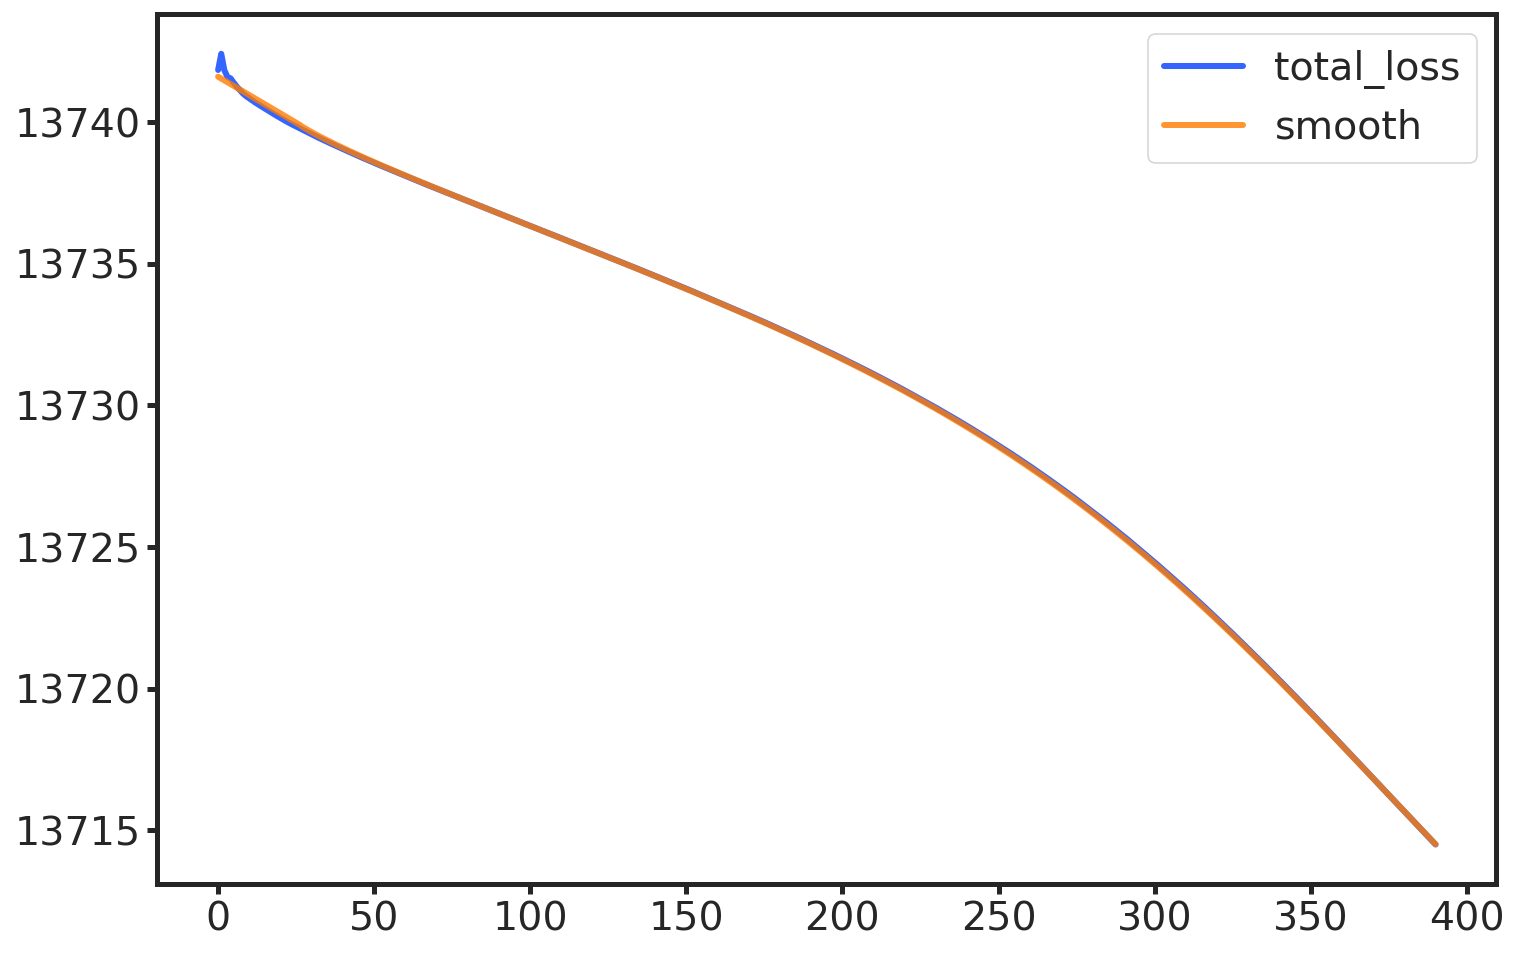

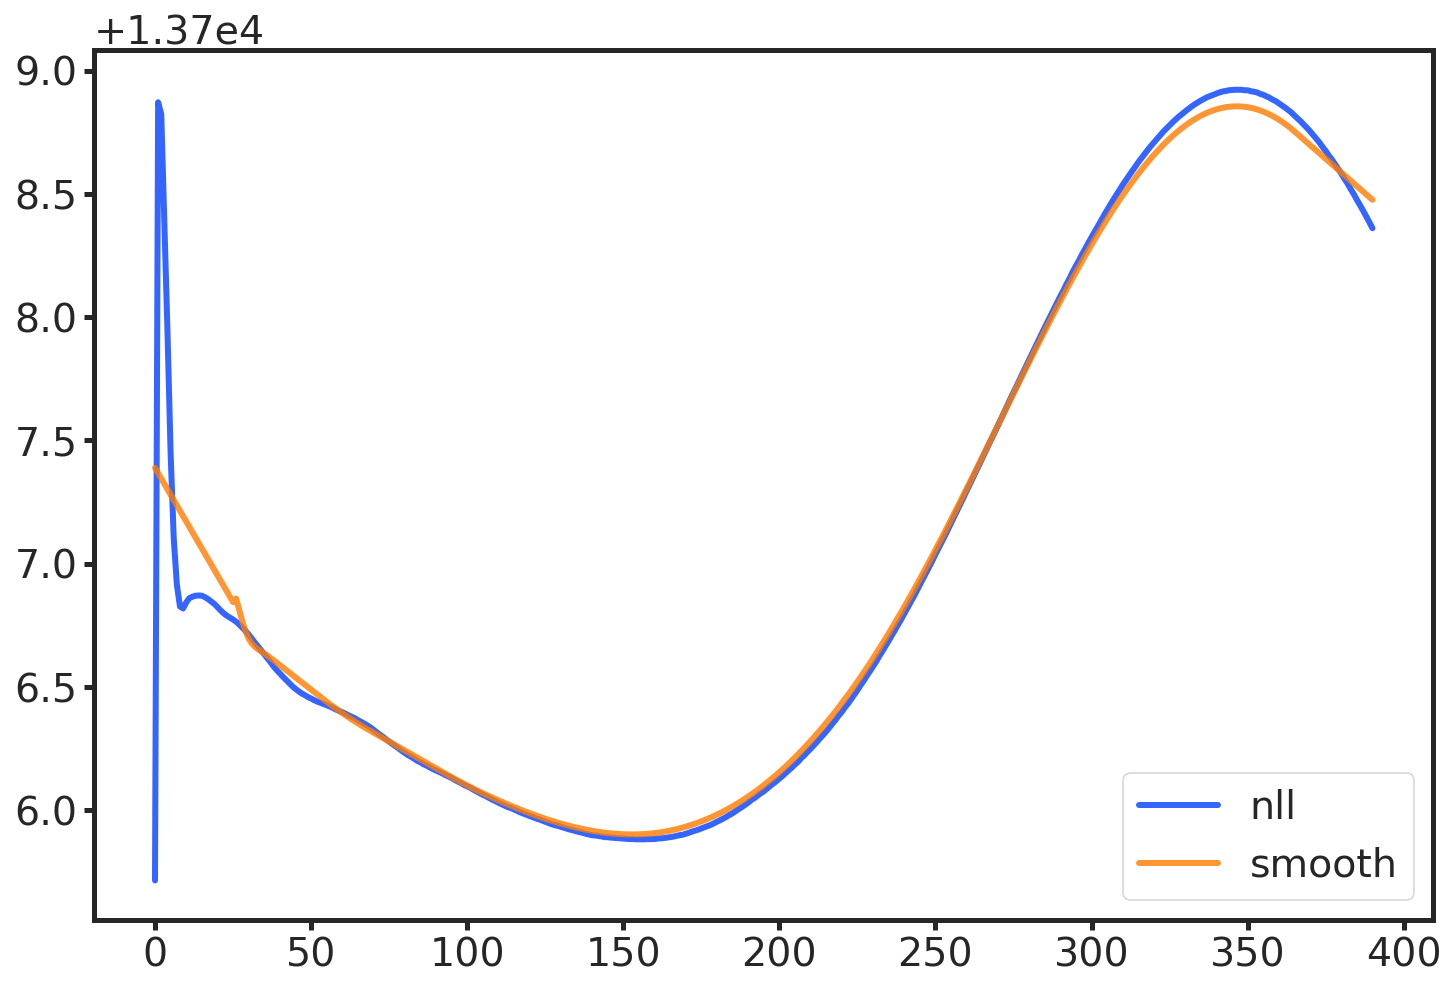

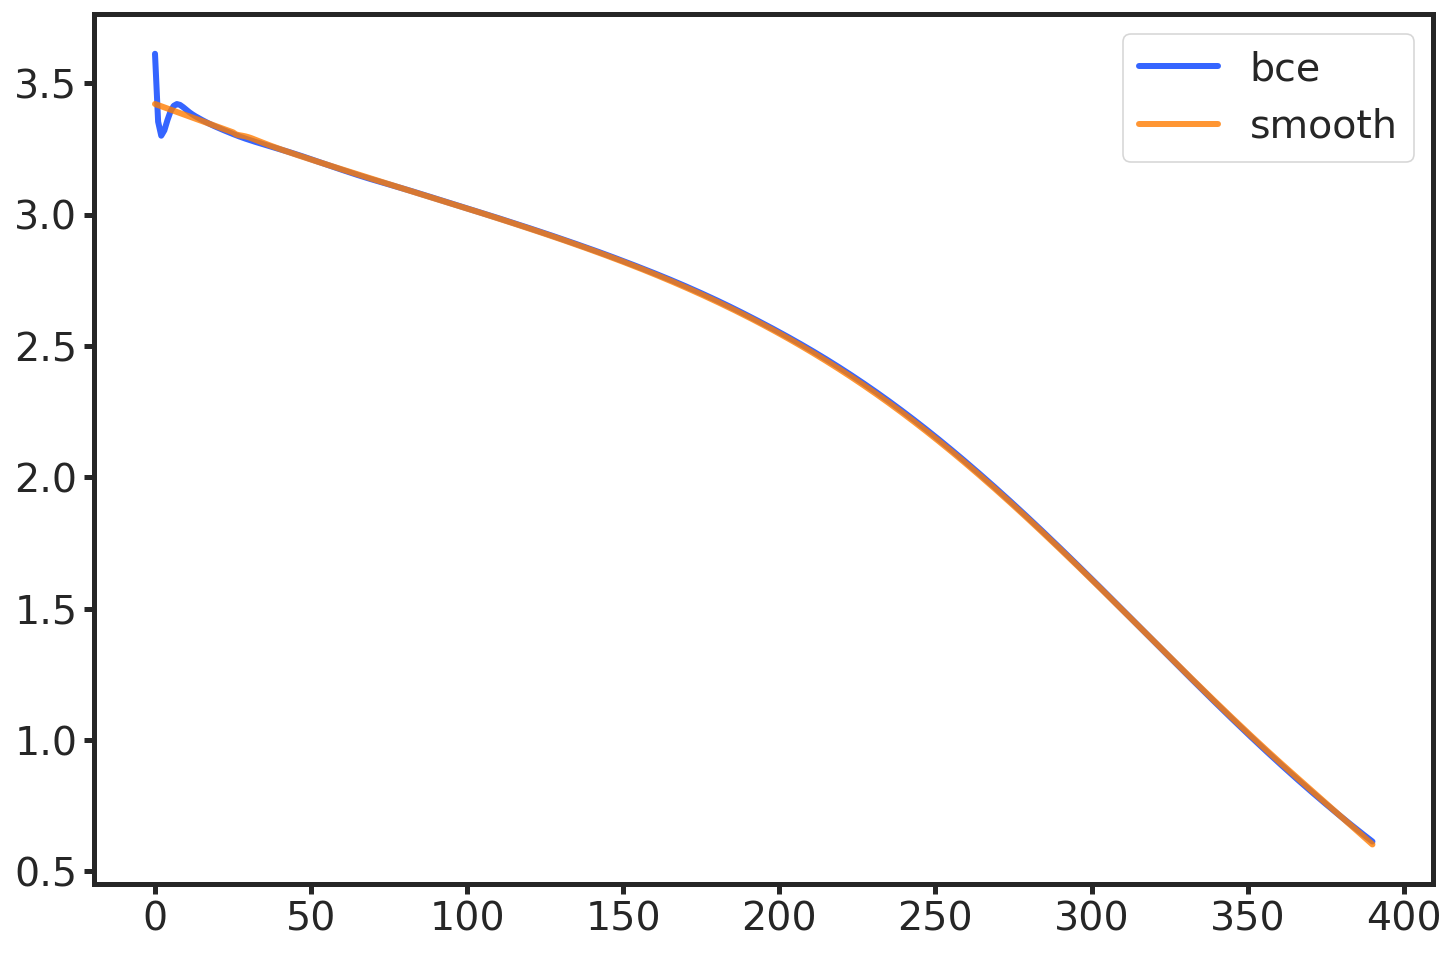

In [81]:
from scipy.signal import savgol_filter

for key in ['total_loss', 'nll', 'bce']:
    plt.plot(results_df[key], label=key, alpha=0.8)
    #plt.hlines(y=target_loss.detach().cpu().numpy(), xmin=0, xmax=results_df.shape[0], colors="green")
    smooth_loss = savgol_filter(results_df[key], window_length=51, polyorder=1)
    plt.plot(smooth_loss, label='smooth', alpha=0.8)
    plt.legend()
    plt.show()

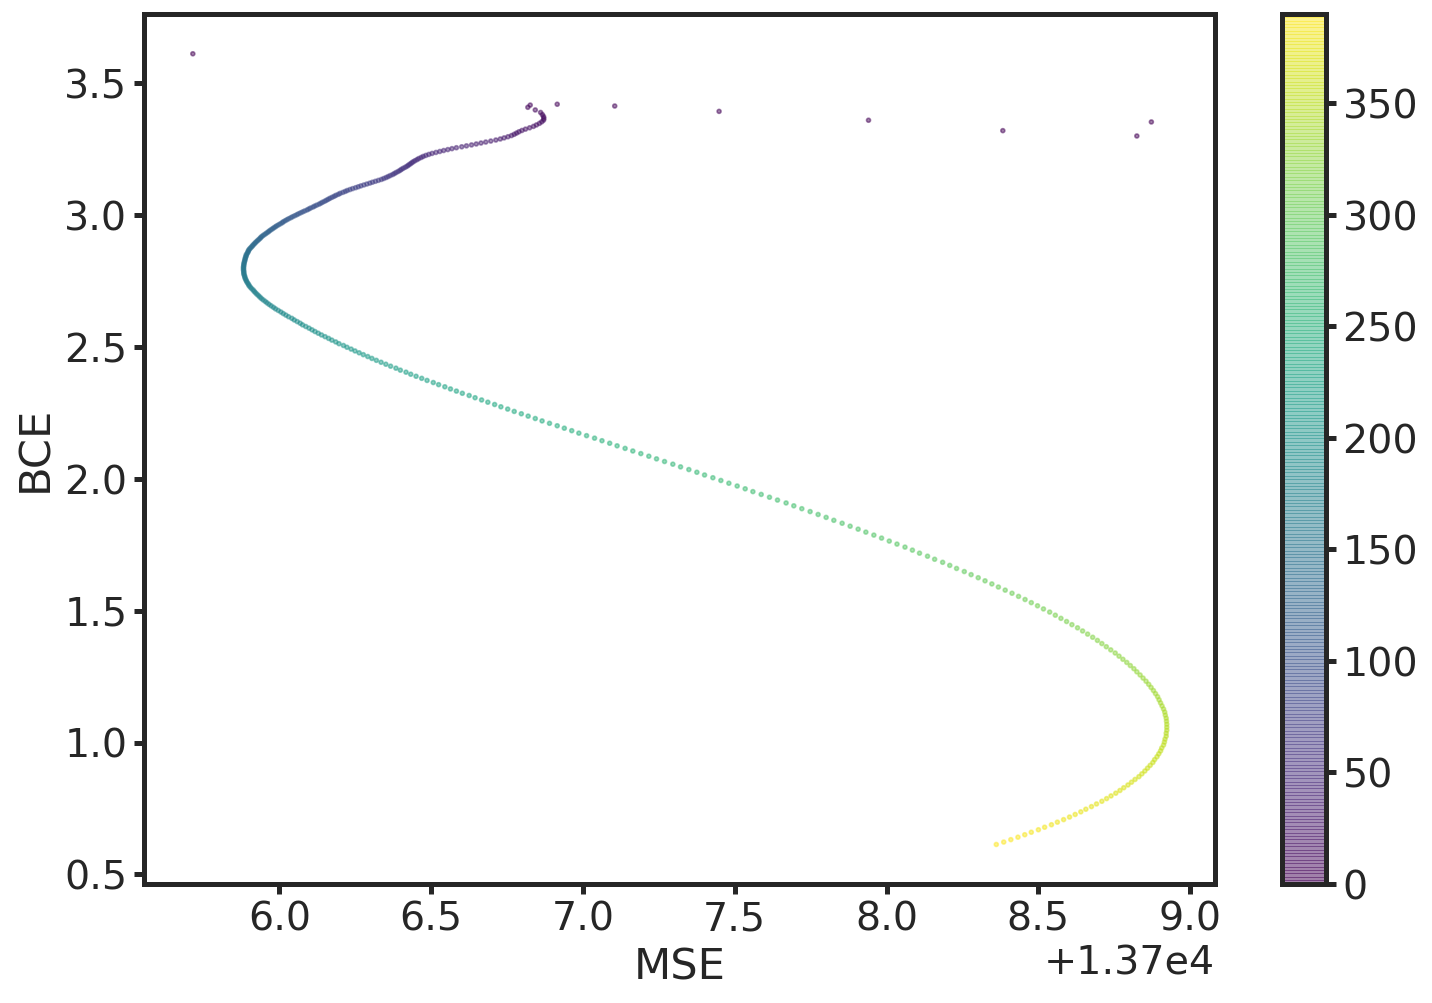

In [82]:
plt.scatter(x='nll', y='bce', c='iter', s=4,
            cmap='viridis', alpha=0.5, data=results_df)
plt.colorbar()
plt.xlabel("MSE")
plt.ylabel("BCE")
plt.show()

## Save models, configs, results

Check: there will be an error if directory already exists (comment if you want to overwrite)

In [24]:
MODEL_DIR

'latent_space_structure/data/citeseq_rna_naiveB_1900_memoryB_100/pca_ae_50'

In [151]:
## save model
os.makedirs(MODEL_DIR)
with open(os.path.join(MODEL_DIR,'config.json'),'w') as afile:
    afile.write(json.dumps(CONFIG.to_dict()))
    
for key, model in {'enc_model_params':enc, 'dec_model_params':dec,'adam_state':optimizer}.items():    
    fname = os.path.join(MODEL_DIR,f'{PREFIX}_{key}.pt' )
    torch.save(model.state_dict(), fname)

results_df.to_csv(os.path.join(MODEL_DIR,f'{PREFIX}_results.csv'),index=False)

In [152]:
os.path.join(MODEL_DIR,f'{PREFIX}_results.csv')

'latent_space_structure/data/citeseq_rna_naiveB_1900_memoryB_100/pca_ae_5/citeseq_rna_results.csv'

In [153]:
CONFIG

batch_size: 20000
betas: !!python/tuple
- 0.99
- 0.999
gene_dim: 17009
label0_weight: 1.0
learning_rate: 0.0001
n_beads: 2000
num_epochs: 4000
puck_number: naiveB_1900_memoryB_100
train_logistic: false
w_logistic: 5.0
z_dim: 5

In [64]:
def get_z_from_enc(enc, x_ng):
    
    enc.eval()
    z_nk = enc(x_ng)
    z_nk = z_nk.detach().cpu().numpy()

    return z_nk

def plot_umap(adata, title_str, 
              color=scaled_log_normalized_expression_ng.sum(axis=1)):
    #plt.figure(figsize=(8, 8))
    plt.scatter(x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1], 
                c=color, s=5, alpha=0.5)
    plt.axis("equal")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.set_cmap("viridis_r")
    plt.colorbar()
    plt.title(title_str)

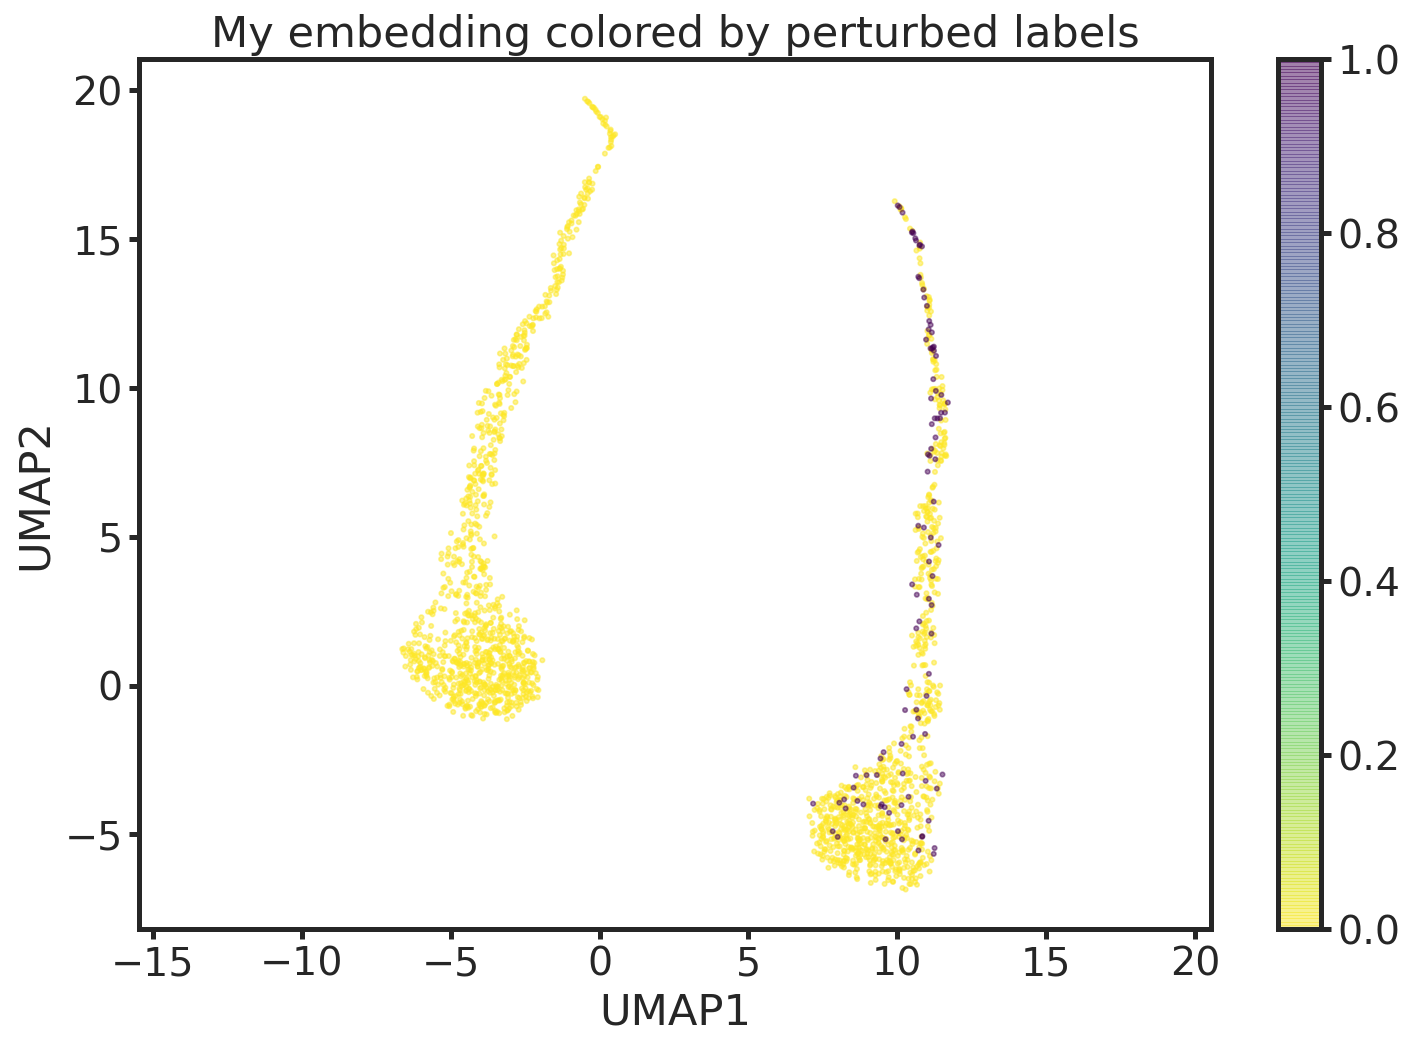

In [67]:
x_ng = torch.from_numpy(scaled_log_normalized_expression_ng).to(device)
z_nk = get_z_from_enc(enc, x_ng)

adata_model = sc.AnnData(x_ng.detach().cpu().numpy())
adata_model.var_names = anndata.utils.make_index_unique(pd.Index(adata.var['gene_ids'].index))
adata_model.var['gene_ids'] = adata.var['gene_ids'].index
adata_model.obs['barcodes'] = adata.obs['barcodes'].values

adata_model.obsm["z_nk"] = z_nk

sc.pp.neighbors(adata_model, use_rep="z_nk", n_neighbors=10)
sc.tl.umap(adata_model)

adata_model
plot_umap(adata_model, title_str='My embedding colored by perturbed labels', color=perturbed=='Memory B')

In [68]:


#X = z_nk#.detach().cpu().numpy()
#y = adata.obs['batch']


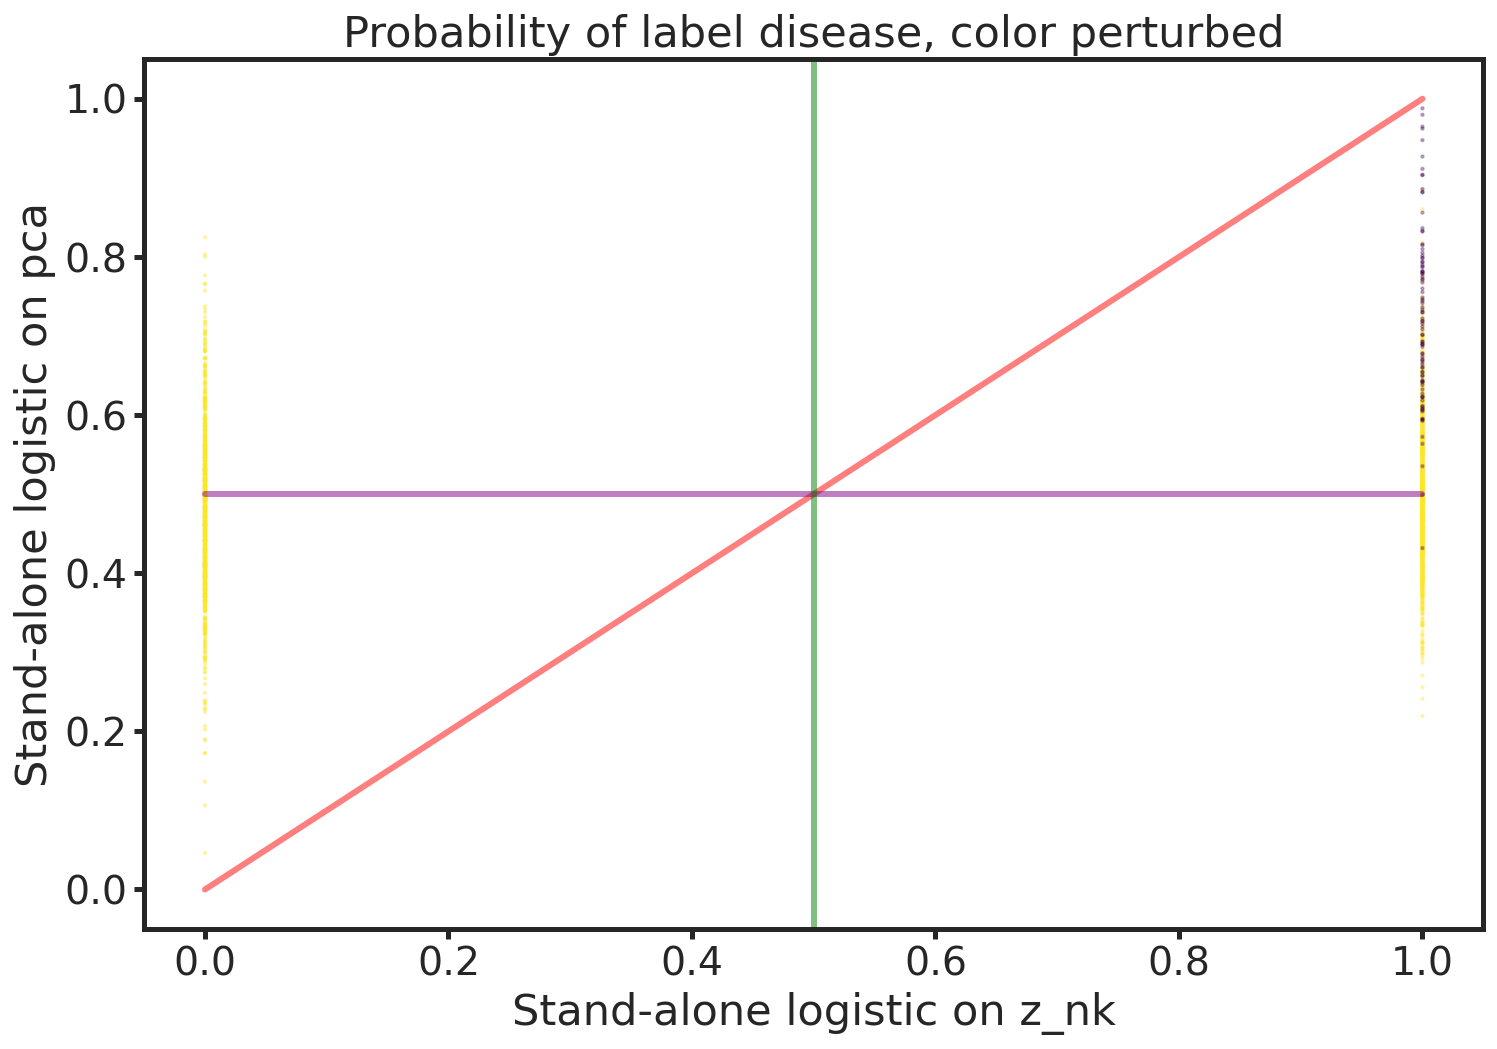

In [73]:

plt.plot([0, 1], c='red', alpha=0.5)
plt.plot([0.5, 0.5], c='purple', alpha=0.5)
plt.axvline(x=0.5, c='green', alpha=0.5)
plt.scatter(x=standalone_logistic(z_nk, adata.obs['batch']), 
            y=standalone_logistic(adata.obsm['X_pca'], adata.obs['batch']), 
            c=perturbed=='Memory B', 
            s=2, alpha=0.3)
plt.title("Probability of label disease, color perturbed")
plt.xlabel("Stand-alone logistic on z_nk")
plt.ylabel("Stand-alone logistic on pca")
plt.show()

In [79]:
prob_vec = standalone_logistic(z_nk, adata.obs['batch'])
#plt.figure(figsize=(20, 10))
#plt.subplot(2, 2, 1)
#sns.histplot(prob_vec[adata.obs['batch']==0], color="#1B9E77")
#sns.histplot(prob_vec[adata.obs['batch']==1], color="#D95F02")
#plt.title(f'Epoch {epoch}, Predicted probability of disease, global labels')
#plt.subplot(2, 2, 2)
#sns.histplot(prob_vec[perturbed=='Naive B'], color='gray')
#sns.histplot(prob_vec[perturbed=='Memory B'], color='red')
#plt.title('Predicted probability of disease, true labels')
plt.show()

In [96]:
np.max(standalone_logistic(z_nk, adata.obs['batch'])[batch==0])
np.min(standalone_logistic(z_nk, adata.obs['batch'])[batch==1])

np.mean(standalone_logistic(z_nk, adata.obs['batch'])[perturbed=='Naive B'])
np.min(standalone_logistic(z_nk, adata.obs['batch'])[perturbed=='Memory B'])

0.9999982998505949